In [1]:
# ==============================================================================
# DISCLAIMER IMPORTANTE PARA AMBIENTES GOOGLE COLAB
# ==============================================================================
# Como o Google Colab fornece um ambiente de execução temporário, ele não vem
# com Java ou Spark pré-instalados. Portanto, este bloco de código DEVE SER
# EXECUTADO TODA VEZ que você iniciar ou reiniciar uma sessão (runtime) no Colab
# para instalar e configurar todas as dependências necessárias para o PySpark.
# ==============================================================================


# --- Bloco de Instalação e Configuração do Ambiente Spark ---

# 1. Instalação do Java
# O Apache Spark é executado sobre a Java Virtual Machine (JVM), então o Java é um pré-requisito obrigatório.
# !apt-get update -qq: Atualiza a lista de pacotes do sistema operacional (baseado em Debian/Ubuntu). O '-qq' torna a saída mais silenciosa.
!apt-get update -qq
# !apt-get install: Instala o OpenJDK 11 (uma versão de código aberto do Java) sem interação do usuário (-y).
!apt-get install -y openjdk-11-jdk-headless

# 2. Download do Spark
# Baixa os binários pré-compilados do Apache Spark a partir do site oficial de arquivamento da Apache.
# !wget -q: Baixa o arquivo da URL especificada. O '-q' (quiet) minimiza as mensagens de log durante o download.
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# 3. Extração do Spark
# Descompacta o arquivo .tgz que foi baixado no passo anterior.
# !tar -xvzf:
#   x: eXtract (extrair)
#   v: verbose (mostra os arquivos sendo extraídos)
#   z: gZip (indica que o arquivo está compactado com gzip)
#   f: file (especifica o nome do arquivo a ser descompactado)
!tar -xvf spark-3.5.1-bin-hadoop3.tgz

# 4. Configuração das Variáveis de Ambiente
# Define as variáveis de ambiente para que o sistema operacional e o Python saibam onde encontrar as instalações do Java e do Spark.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# 5. Instalação das bibliotecas Python para Spark
# Instala as bibliotecas Python necessárias para interagir com o Spark.
# !pip install -q: Instala os pacotes usando o gerenciador de pacotes do Python (pip) em modo silencioso.
#   pyspark==3.5.1: A biblioteca que fornece a API Python para o Spark. A versão é fixada para corresponder à versão do Spark baixada.
#   findspark: Uma biblioteca útil que ajuda o Python a localizar a instalação do Spark no sistema.
!pip install -q pyspark==3.5.1 findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.27+6~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/spark-daemon.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-worker.sh
s

In [2]:
from google.colab import drive, files
from pyspark.sql import SparkSession
import findspark
import requests
import gzip
import tarfile
import os
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import Row
from pyspark.sql.functions import col, count, sum, avg, when
findspark.init()



In [3]:
spark = SparkSession.builder \
    .appName("IFood Test Case") \
    .getOrCreate()

spark

In [4]:
###################################################################################
# SEÇÃO DE CONFIGURAÇÃO: ORIGEM DOS DADOS
# ---------------------------------------------------------------------------------
# Define se os arquivos de dados serão lidos a partir do Google Drive ou de uma
# pasta local (uploaded).
###################################################################################

# Variável de controle para a fonte dos dados.
# Opções válidas:
#   "drive": Para carregar os arquivos diretamente de uma pasta no Google Drive.
#   "uploaded": Para carregar os arquivos de um diretório local.
data_source = "drive"

# Define o caminho base no Google Drive onde os arquivos de dados estão localizados.
# Esta variável só é utilizada se 'data_source' for definida como "drive".
# Exemplo de estrutura de pastas: drive/MyDrive/iFood/Data/Bronze/
drive_silver_path = "drive/MyDrive/iFood/Data/Silver"
upload_silver_path = "./Data/Silver"  ##Pode variar caso os .parquets nao sejam exatamente os criados no primeiro notebook.

if data_source == "drive":
    drive.mount('/content/drive')
    silver_path = drive_silver_path
else:
    silver_path = upload_silver_path


Mounted at /content/drive


In [ ]:
### apenas para o fluxo usando upload manual...###########
######################################################

# Criar diretório local para salvar os arquivos
os.makedirs('Data', exist_ok=True)
# depois faca o upload dos zip nessa pasta, caso nao esteja usando o fluxo do google drive.


In [ ]:
### apenas para o fluxo usando upload manual...###########
######################################################

# Define uma variável para armazenar o nome da pasta onde os arquivos .zip
# devem ser encontrados. O caminho "./Data" refere-se a uma pasta chamada "Data"
# localizada no mesmo nível do diretório de execução do notebook (/content/).
caminho_da_pasta_zip = "./Data"


# Imprime uma mensagem informativa para o usuário saber qual ação está sendo executada.
print(f"\nProcurando arquivos .zip em: {caminho_da_pasta_zip}")

# Bloco de verificação para garantir que a pasta de origem existe.
# Se a pasta não for encontrada, o script exibe um erro claro em vez de falhar.
if not os.path.isdir(caminho_da_pasta_zip):
    print(f"ERRO: O diretório '{caminho_da_pasta_zip}' não foi encontrado.")
    print("Por favor, verifique o caminho e tente novamente.")
else:
    # Se a pasta existe, esta linha obtém uma lista de todos os nomes de arquivos e subpastas dentro dela.
    arquivos_na_pasta = os.listdir(caminho_da_pasta_zip)

    # Inicializa uma variável de controle para rastrear se algum arquivo .zip foi processado.
    zip_encontrado = False

    # Inicia um loop para examinar cada item encontrado na pasta de origem.
    for nome_arquivo in arquivos_na_pasta:
        # Condição para filtrar e processar apenas os itens que são arquivos .zip.
        if nome_arquivo.endswith(".zip"):
            # Atualiza a variável de controle, indicando que pelo menos um zip foi encontrado.
            zip_encontrado = True
            # Constrói o caminho completo para o arquivo .zip, unindo o nome da pasta e o nome do arquivo.
            caminho_completo_zip = os.path.join(caminho_da_pasta_zip, nome_arquivo)

            print(f"  -> Descompactando '{nome_arquivo}'...")

            # Utiliza um comando de shell (!unzip) para extrair o conteúdo do arquivo.
            # A opção "-o" força a substituição de arquivos existentes sem pedir permissão.
            # A opção "-d /content/" especifica o diretório de destino para a extração.
            !unzip -o "{caminho_completo_zip}" -d /content/

    # Após o loop, se a variável de controle não mudou, significa que nenhum zip foi processado.
    if not zip_encontrado:
        print("Nenhum arquivo .zip foi encontrado na pasta especificada.")

# Mensagem final para indicar que todas as operações foram concluídas.
print("\nProcesso de descompactação concluído! ✅")


# Bloco final para verificação visual dos resultados.
# O comando de shell "!ls" lista o conteúdo do diretório especificado.
print("\nConteúdo extraído no diretório (/content/Data/Bronze/):")
!ls -l /content/Data/Bronze

In [5]:
# Caminhos para os dados de pedidos
orders_silver_path = f"{silver_path}/orders.parquet"

# Caminhos para os dados de consumidores
consumers_silver_path = f"{silver_path}/consumers.parquet"

# Caminhos para os dados de restaurantes
restaurants_silver_path = f"{silver_path}/restaurants.parquet"

# Caminhos para os dados de referencia do teste A/B
ab_test_silver_path = f"{silver_path}/ab_test_ref.parquet"


In [6]:
dfp_orders = spark.read.parquet(orders_silver_path)
dfp_consumers = spark.read.parquet(consumers_silver_path)
dfp_restaurants = spark.read.parquet(restaurants_silver_path)
dfp_ab_test = spark.read.parquet(ab_test_silver_path)

In [ ]:
# --- Bloco de Verificação: Validação da Carga de Dados na Camada Silver ---
#
# O objetivo deste bloco é realizar um teste de sanidade (sanity check) para
# garantir que a ingestão de dados para a camada Silver ocorreu como esperado.
#

# Contagem de registros no DataFrame de pedidos (orders).
print("Contagem de registros em 'dfp_orders':")
print(dfp_orders.count())

# Contagem de registros no DataFrame de consumidores (consumers).
print("\nContagem de registros em 'dfp_consumers':")
print(dfp_consumers.count())

# Contagem de registros no DataFrame de restaurantes (restaurants).
print("\nContagem de registros em 'dfp_restaurants':")
print(dfp_restaurants.count())

# Contagem de registros no DataFrame de teste A/B (ab_test).
print("\nContagem de registros em 'dfp_ab_test':")
print(dfp_ab_test.count())

Contagem de registros em 'dfp_orders':
2427415

Contagem de registros em 'dfp_consumers':
804559

Contagem de registros em 'dfp_restaurants':
7292

Contagem de registros em 'dfp_ab_test':
804559


In [ ]:
print("--- Schema da Tabela: orders ---")
# Exibe a estrutura (colunas, tipos e nulidade) da tabela de pedidos.
dfp_orders.printSchema()

print("\n--- Schema da Tabela: consumers ---")
# Exibe a estrutura da tabela de clientes.
dfp_consumers.printSchema()

print("\n--- Schema da Tabela: restaurants ---")
# Exibe a estrutura da tabela de restaurantes.
dfp_restaurants.printSchema()

print("\n--- Schema da Tabela: ab_test ---")
# Exibe a estrutura da tabela de referência do teste A/B.
dfp_ab_test.printSchema()

--- Schema da Tabela: orders ---
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_total_amount: double (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- origin_platform: string (nullable = true)
 |-- order_category: string (nullable = true)


--- Schema da Tabela: consumers ---
root
 |-- customer_id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- customer_phone_state: string (nullable = true)


--- Schema da Tabela: restaurants ---
root
 |-- id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- price_range: integer (nullable = true)
 |-- average_ticket: double (nullable = true)
 |-- delivery_time: intege

###DESAFIO 1####
No iFood, várias áreas utilizam testes A/B para avaliar o impacto de
ações em diferentes métricas. Esses testes permitem validar hipóteses
de crescimento e a viabilidade de novas funcionalidades em um grupo
restrito de usuários. Nos dados fornecidos nesse case você encontrará
uma marcação de usuários, separando-os entre grupo teste e controle
de uma campanha de cupons, que disponibilizou para os usuários do
grupo teste um cupom especial.

- a) Defina os indicadores relevantes para mensurar o sucesso da
campanha e analise se ela teve impacto significativo dentro do
período avaliado.

- b) Faça uma análise de viabilidade financeira dessa iniciativa
como alavanca de crescimento, adotando as premissas que jul
gar necessárias (explicite as premissas adotadas).

- c) Recomende oportunidades de melhoria nessa ação e dese
nhe uma nova proposta de teste A/B para validar essas hipóte
ses.

# Desafio 1-a)Plano de Análise e Definição de KPIs para o Teste A/B

> Este documento estabelece a estratégia de análise e os indicadores de sucesso (KPIs) para avaliar a campanha de cupons. O plano foi enriquecido com o contexto do modelo de negócios do iFood para garantir que a análise meça não apenas a atividade dos usuários, mas principalmente o **impacto real e financeiro** para a companhia.

---

## 1. Contextualização: Como o iFood Gera Receita

Para uma análise de dados eficaz, é fundamental entender o modelo de negócio da empresa. O iFood opera como um **marketplace de três lados**, conectando clientes, restaurantes e entregadores. Sua receita principal não vem da venda direta de comida, mas sim dos serviços prestados aos seus parceiros, os restaurantes.

As principais fontes de receita são as comissões sobre os pedidos e as mensalidades dos planos oferecidos aos restaurantes:

* **Plano Básico:** Cobra uma comissão de **12%** sobre o valor total dos pedidos, mais uma taxa de 3,5% em pagamentos online. A entrega é de responsabilidade do restaurante.
* **Plano Entrega:** Cobra uma comissão significativamente maior, de **27%**, e a logística de entrega fica a cargo do iFood.

Este modelo tem uma implicação direta na nossa análise: **a lucratividade de um pedido para o iFood depende drasticamente do plano do restaurante parceiro**. Um cupom que incentiva pedidos em restaurantes de baixa comissão pode ter um impacto líquido negativo, mesmo que aumente o volume de vendas.

---

## 2. A Estratégia de Análise: Do Ideal ao Praticável

Uma análise robusta começa pelo reconhecimento das limitações dos dados. Elas ditam a abordagem metodológica e demonstram pensamento crítico.

### 2.1. Limitações Críticas dos Dados

Identificamos duas limitações principais nos datasets fornecidos que direcionam nossa estratégia:

1.  **Ausência das Datas da Campanha:** Não sabemos quando a campanha de cupons esteve ativa. Isso nos impede de calcular métricas de impacto direto, como o **aumento de vendas durante o período promocional** ou a taxa de adesão ao cupom. Por essa razão, a análise não pode ser longitudinal (pré vs. pós), devendo ser **transversal** (comparação do comportamento agregado do grupo teste vs. controle durante toda a janela de dados).

2.  **Ausência de Dados do Plano do Restaurante:** Conforme discutido, não temos a informação do plano de assinatura de cada restaurante (`'Básico'` ou `'Entrega'`). Isso nos impede de calcular a **receita de comissão real** para o iFood, que seria a métrica de sucesso financeiro mais precisa.

### 2.2. A Solução: Análise Transversal com Proxies

Dadas as limitações, nossa abordagem será:
* **Comparar** o comportamento médio dos usuários do grupo teste com o do grupo controle ao longo de todo o período disponível (Dez/18 a Jan/19).
* **Utilizar variáveis proxy** para estimar o impacto no valor gerado para o negócio, mesmo sem os dados de comissão.

---

## 3. Detalhamento dos KPIs Selecionados para Análise

A seguir, detalhamos cada KPI escolhido, explicando seu objetivo e a hipótese a ser testada.

### 3.1. Métrica Primária (Foco em Retenção)

#### Taxa de Conversão para Compra Repetida
* **Objetivo:** Medir diretamente a retenção. Responde à pergunta: "O cupom incentivou os usuários a voltarem e fazerem um novo pedido dentro da janela de observação?"
* **Hipótese ($H_A$):** O grupo teste (que recebeu o cupom) terá uma proporção maior de usuários com 2 ou mais pedidos do que o grupo de controle. Em avaliação estatistica- Existe uma associação entre pertencer a um grupo do teste A/B e o status de retenção do usuário. As duas variáveis são dependentes.

### 3.2. Métricas Secundárias (Visão de Engajamento)

#### Frequência de Compra
* **Objetivo:** Avaliar o nível de engajamento geral. Responde à pergunta: "O grupo teste passou a fazer pedidos com maior frequência?"
* **Hipótese ($H_A$):** A média de pedidos por usuário será maior no grupo teste.

#### Dias de Atividade Por Usuário
* **Objetivo:** Entender a profundidade do engajamento. Mede se o iFood se tornou um hábito, sendo utilizado em dias distintos, o que indica uma lealdade mais forte.
* **Hipótese ($H_A$):** Usuários do grupo teste farão pedidos em uma quantidade maior de dias diferentes.

### 3.3. Métricas de Guarda (Protegendo o Ecossistema e a Receita)

#### Ticket Médio (AOV)
* **Objetivo:** Monitorar a canibalização e a lucratividade. Responde à pergunta: "O cupom levou os usuários a fazerem pedidos de menor valor, impactando a rentabilidade por pedido?"
* **Hipótes-e ($H_A$):** O Ticket Médio do grupo teste será menor ou igual ao do grupo controle. Um resultado significativamente menor é um sinal de alerta.

#### Impacto em Restaurantes de Alto Valor (Proxy)
* **Objetivo:** Avaliar o impacto da campanha no comportamento do consumidor em relação a restaurantes de "alto valor", que servem como um proxy para parceiros de maior rentabilidade para o iFood. A análise é feita sob duas óticas complementares: a proporção do valor gasto (R$) e a proporção do volume de pedidos.

* **Hipóteses:** Como a análise é dupla, definimos dois pares de hipóteses:

    * **Para a Análise de Gasto (Teste Z):**
        * **$H_0$ (Hipótese Nula):** A proporção do **valor total gasto** em restaurantes de alto valor é a mesma entre os grupos Teste e Controle.
        * **$H_A$ (Hipótese Alternativa):** A proporção do **valor total gasto** em restaurantes de alto valor é diferente entre os grupos.

    * **Para a Análise de Volume de Pedidos (Teste Qui-Quadrado):**
        * **$H_0$ (Hipótese Nula):** Não há associação entre pertencer a um grupo de teste e a escolha de um restaurante de alto valor. A proporção de **pedidos** em restaurantes de alto valor é a mesma entre os grupos.
        * **$H_A$ (Hipótese Alternativa):** Existe uma associação entre o grupo do teste e a escolha de um restaurante de alto valor. A proporção de **pedidos** é diferente entre os grupos.
---

## 4. Framework de Análise e Critérios de Decisão

Para traduzir os resultados dos testes estatísticos em uma conclusão de negócio clara, utilizaremos o seguinte framework.

### 4.1. Os Pilares do "Impacto Significativo"
Um impacto é considerado significativo quando satisfaz dois critérios:

* **Significância Estatística:** Garante que a diferença observada entre os grupos teste e controle não é uma mera coincidência.
    * **Método:** Utilizaremos o **p-valor**. Se `p-valor < 0.05`, rejeitamos a hipótese nula ($H_0$) e consideramos o resultado estatisticamente significativo.

* **Significância Prática (de Negócio):** Avalia se a magnitude da diferença é grande o suficiente para justificar os custos e esforços da iniciativa.
    * **Método:** Analisaremos o **Lift** (aumento percentual) e o **Intervalo de Confiança de 95%** para entender o tamanho e a confiabilidade do efeito.

### 4.2. Processo de Avaliação para Cada KPI
Para cada indicador definido, o processo para chegar a uma conclusão será:

1.  **Veredito Estatístico:** Executar o teste estatístico apropriado e comparar o p-valor com $\alpha=0.05$ para aceitar ou rejeitar a hipótese.
2.  **Quantificação do Impacto:** Calcular o Lift percentual e o Intervalo de Confiança para entender a magnitude do efeito.
3.  **Síntese Individual:** Formular uma frase-conclusão que combina o veredito estatístico com a magnitude do impacto, deixando claro se o resultado foi ou não significativo.

### 4.3. Estrutura da Conclusão Final
A conclusão geral do projeto seguirá uma narrativa estruturada:
1.  **Veredito da Métrica Primária:** A campanha atingiu seu objetivo principal?
2.  **Análise das Métricas Secundárias:** Como elas suportam ou contradizem o resultado primário?
3.  **Análise das Métricas de Guarda:** Houve algum efeito colateral negativo?
4.  **Síntese Final:** Um parágrafo conclusivo que equilibra todos os pontos e dá um veredito final sobre o impacto da campanha.

---

## 5. Tabela Resumo dos KPIs

A tabela abaixo consolida todos os indicadores que serão medidos, especificando o racional e o método de análise.

| Categoria | KPI (Indicador de Sucesso) | Objetivo & Racional | Hipótese | Método / Status |
| :--- | :--- | :--- | :--- | :--- |
| **🏆 Primária** | **Taxa de Conversão para Compra Repetida** | Medir a retenção e a "aderência" do usuário na plataforma. | $H_A$: Teste > Controle | **Direto (Praticável)** |
| **📊 Secundária** | **Frequência de Compra** | Avaliar o engajamento e a criação de hábito de consumo. | $H_A$: Teste > Controle | **Direto (Praticável)** |
| **📊 Secundária** | **Dias de Atividade Por Usuário** | Entender a profundidade do engajamento e se o iFood se tornou parte da rotina do usuário. | $H_A$: Teste > Controle | **Direto (Praticável)** |
| **🛡️ Guarda** | **Ticket Médio (AOV)** | Monitorar se o cupom incentiva pedidos de menor valor, o que **reduz o valor da comissão por pedido**. | $H_0$: Teste ≤ Controle | **Direto (Praticável)** |
| **🛡️ Guarda** | **Proporção de Gasto em Restaurantes de Alto Valor** | **(Proxy)** Monitorar se o cupom dilui a receita ao deslocar a demanda para parceiros menos lucrativos. | $H_0$: Teste = Controle | **Proxy (Praticável)** |
| **✨ Ideal** | **Aumento de Vendas na Campanha** | Medir o *lift* de vendas direto durante o período em que o cupom esteve ativo. | $H_A$: Teste > Controle | **Ideal (Não Praticável)** |
| **✨ Ideal** | **Receita de Comissão Por Usuário (CRPU)** | Medir o **lucro real (comissão)** gerado por usuário. O principal indicador de sucesso financeiro. | $H_A$: Teste > Controle | **Ideal (Não Praticável)** |

---

## 6. Conclusão do Plano e Próximos Passos

Esta estrutura de análise avalia a campanha de forma holística, equilibrando a medição do comportamento do usuário com o impacto financeiro no ecossistema iFood, ao mesmo tempo em que reconhece e contorna as limitações dos dados.

A principal recomendação para o negócio, que será detalhada na conclusão do projeto, é a **necessidade de enriquecer os datasets de análise com dados de negócio cruciais**, como o plano dos restaurantes parceiros e as datas de validade das campanhas. A implementação dessas melhorias permitirá futuras análises de ROI muito mais precisas e estratégicas.

O load para camada silver do df de orders ocorreu antes do que o df de consumers. Apesar de termos tratado isso no load de orders, podemos novamente ter casos de orders apontando para consumers que nao existem no df de consumers tratado.

In [ ]:

print("\n--- Bloco de Verificação: customer_id em dfp_orders existe em dfp_consumers ---")

# Coleta todos os customer_id únicos do DataFrame dfp_orders.
# Utiliza `collect()` para trazer os resultados para o driver,
# o que é adequado se a lista de IDs não for excessivamente grande.
# Caso contrário, seria melhor fazer a verificação no Spark.
order_customer_ids = set([row.customer_id for row in dfp_orders.select("customer_id").distinct().collect()])

# Coleta todos os customer_id únicos do DataFrame dfp_consumers.
consumer_ids = set([row.customer_id for row in dfp_consumers.select("customer_id").distinct().collect()])

# Encontra os customer_id que estão em dfp_orders mas não em dfp_consumers.
missing_customer_ids = order_customer_ids - consumer_ids

# Verifica se a lista de IDs faltantes está vazia.
if not missing_customer_ids:
    print("✅ Todos os customer_id referenciados em dfp_orders existem em dfp_consumers.")
else:
    print(f"❌ Encontrados {len(missing_customer_ids)} customer_id em dfp_orders que NÃO existem em dfp_consumers.")
    # Opcional: Imprimir alguns dos IDs faltantes para inspeção
    # print("Exemplos de customer_id faltantes:", list(missing_customer_ids)[:10])

print("--- Verificação concluída. ---")



--- Bloco de Verificação: customer_id em dfp_orders existe em dfp_consumers ---
❌ Encontrados 1597 customer_id em dfp_orders que NÃO existem em dfp_consumers.
--- Verificação concluída. ---


Na mesma linha do que foi feito na limpeza para carregar a camada silver, os dados orfaos serao removidos

In [7]:
print("\n--- Filtrando dfp_orders para manter apenas customer_id válidos ---")

# Seleciona apenas os customer_id válidos da base de consumidores
valid_customers_df = dfp_consumers.select("customer_id").distinct()

# Realiza um inner join entre dfp_orders_cleaned e os customer_id válidos
dfp_orders_filtered = dfp_orders.join(
    valid_customers_df,
    on="customer_id",
    how="inner"
)

# Verificação de quantos registros foram removidos
original_count = dfp_orders.count()
filtered_count = dfp_orders_filtered.count()
removed_count = original_count - filtered_count

print(f"Filtragem concluída. {removed_count} registros com customer_id inválidos foram removidos.")
print(f"Total original: {original_count}")
print(f"Total após filtragem: {filtered_count}")



--- Filtrando dfp_orders para manter apenas customer_id válidos ---
Filtragem concluída. 5936 registros com customer_id inválidos foram removidos.
Total original: 2426590
Total após filtragem: 2420654


In [8]:
dfp_orders_filtered.select("customer_id").distinct().count()

804559

In [9]:
dfp_consumers.select("customer_id").distinct().count()

804559

In [13]:
dfp_ab_test.select("customer_id").distinct().count()

804559

##	Analise KPI 1 -Taxa de Conversão para Compra Repetida ##

In [10]:
# --- Passo 1: Calcular o número de pedidos por cliente ---
# Agrupamos a tabela de pedidos por 'customer_id' e contamos as ocorrências
print("--- Passo 1: Contando pedidos por cliente ---")
dfp_customer_orders = dfp_orders_filtered.groupBy("customer_id").agg(
    count("order_id").alias("order_count")
)
dfp_customer_orders.show(5)

--- Passo 1: Contando pedidos por cliente ---
+--------------------+-----------+
|         customer_id|order_count|
+--------------------+-----------+
|00006f567cb362ba9...|          5|
|0000c21984ae00cef...|         23|
|0001226e517517758...|          2|
|00021cd56b6d6c980...|          3|
|00021f6dc15d10418...|          2|
+--------------------+-----------+
only showing top 5 rows



In [11]:
# --- Passo 2: Juntar os dados de pedidos com os dados do teste A/B ---
# Como os dados da camada silver temos garantia que todos os clientes do teste têm pedidos,
# podemos usar um 'inner' join.

print("\n--- Passo 2: Unindo as bases de dados com 'inner join' ---")
dfp_analysis = dfp_ab_test.join(
    dfp_customer_orders,
    on="customer_id",
    how="inner"
)
dfp_analysis.show(5)


--- Passo 2: Unindo as bases de dados com 'inner join' ---
+--------------------+---------+--------------------+--------------------+-----------+
|         customer_id|is_target|          created_at|customer_phone_state|order_count|
+--------------------+---------+--------------------+--------------------+-----------+
|0001226e517517758...|   target|2018-03-31 23:13:...|                  RJ|          2|
|00021cd56b6d6c980...|   target|2018-01-04 15:16:...|                  PE|          3|
|00021f6dc15d10418...|   target|2018-01-30 21:16:...|                  RS|          2|
|0002287b123ac1afc...|   target|2018-02-04 23:07:...|                  AC|          1|
|00022b8c0c7af061f...|  control|2018-04-06 02:04:...|                  PB|          5|
+--------------------+---------+--------------------+--------------------+-----------+
only showing top 5 rows



In [12]:
# --- Passo 3: Definir a nossa métrica de conversão (retenção) ---
# Criamos uma nova coluna 'is_retained' que será 1 se o cliente fez 2 ou mais pedidos, e 0 caso contrário.
print("\n--- Passo 3: Criando a coluna de retenção ---")
dfp_analysis = dfp_analysis.withColumn(
    "is_retained",
    when(col("order_count") >= 2, 1).otherwise(0)
)
dfp_analysis.select("customer_id", "is_target", "order_count", "is_retained").show(10)


--- Passo 3: Criando a coluna de retenção ---
+--------------------+---------+-----------+-----------+
|         customer_id|is_target|order_count|is_retained|
+--------------------+---------+-----------+-----------+
|00006f567cb362ba9...|   target|          5|          1|
|0001226e517517758...|   target|          2|          1|
|00021cd56b6d6c980...|   target|          3|          1|
|00021f6dc15d10418...|   target|          2|          1|
|0002287b123ac1afc...|   target|          1|          0|
|00022b8c0c7af061f...|  control|          5|          1|
|00027035d16a4de43...|  control|          1|          0|
|00029b26fb2121119...|   target|          1|          0|
|0002cc7394d677fdf...|  control|          1|          0|
|000380791e2338c6f...|  control|          2|          1|
+--------------------+---------+-----------+-----------+
only showing top 10 rows



In [14]:
# Calcular a contagem de clientes únicos por grupo do teste A/B ---
# Contamos o número total de clientes em cada grupo ('is_target' = 1 para teste, 0 para controle).
print("\n---  Contando clientes únicos por grupo ---")
dfp_total_customers_per_group = dfp_analysis.groupBy("is_target").agg(
    count("customer_id").alias("total_customers")
)
dfp_total_customers_per_group.show()


--- Passo 4: Contando clientes únicos por grupo ---
+---------+---------------+
|is_target|total_customers|
+---------+---------------+
|  control|         359699|
|   target|         444860|
+---------+---------------+



In [15]:

print("\n---  Contando clientes únicos por grupo;retained ---")
dfp_total_customers_per_group = dfp_analysis.groupBy("is_target","is_retained").agg(
    count("customer_id").alias("total_customers")
)
dfp_total_customers_per_group.show()


---  Contando clientes únicos por grupo;retained ---
+---------+-----------+---------------+
|is_target|is_retained|total_customers|
+---------+-----------+---------------+
|  control|          0|         188404|
|   target|          0|         188596|
|  control|          1|         171295|
|   target|          1|         256264|
+---------+-----------+---------------+



In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
import math

### Metodologia Estatística: Teste Qui-Quadrado (X²)  ###

A escolha do teste estatístico é um elemento central para validar os KPIs definidos no experimento. No caso de métricas proporcionais — como a **Taxa de Conversão para Compra Repetida** — optamos pelo **Teste Qui-Quadrado de Independência**, dada sua robustez e adequação para variáveis categóricas em grandes amostras.

| Componente | Descrição | Aplicação no Caso iFood |
| :--- | :--- | :--- |
| **🎯 Finalidade** | Avaliar se há uma **associação estatisticamente significativa** entre duas variáveis categóricas. | Verificar se pertencer ao grupo "Teste" está associado a uma maior probabilidade de recompra (retenção). |
| **📜 Hipótese Nula ($H_0$)** | Assume que **não existe relação** entre as variáveis. Diferenças observadas seriam fruto do acaso. | "Não há associação entre estar no grupo 'Teste' e a chance de recompra." |
| **⚙️ Funcionamento** | Compara as frequências **observadas** com as **esperadas** sob $H_0$, calculando um valor de estatística (X²). | Mede se a diferença entre grupos é suficientemente grande para rejeitar o acaso como explicação. |
| **⚖️ Veredito (p-valor)** | Um **p-valor < 0.05** permite rejeitar $H_0$ e concluir que há associação significativa. | Se o p-valor for significativo, há evidência de que a campanha afetou a recompra. |

> O Teste Qui-Quadrado é especialmente indicado para este experimento por sua simplicidade, confiabilidade em grandes volumes de dados e foco em variáveis categóricas — exatamente o perfil da nossa métrica primária.


In [ ]:
# --- Passo 4: Preparação para o Teste Estatístico no PySpark ---
# A função ChiSquareTest do PySpark ML espera colunas numéricas específicas: 'label' e 'features'.
# 1. Converter a coluna 'is_target' (string) para 'label' (numérico).
# 2. "Montar" a coluna 'is_retained' no formato de vetor esperado pela biblioteca.
print("\n--- Passo 4: Preparando os dados para o ChiSquareTest ---")
# Converte 'control'/'target' para 0.0/1.0
label_indexer = StringIndexer(inputCol="is_target", outputCol="label")
dfp_analysis = label_indexer.fit(dfp_analysis).transform(dfp_analysis)

# Monta a coluna 'is_retained' em um vetor de features
feature_assembler = VectorAssembler(inputCols=["is_retained"], outputCol="features")
dfp_prepared = feature_assembler.transform(dfp_analysis)




--- Passo 4: Preparando os dados para o ChiSquareTest ---


In [ ]:
print("Schema do DataFrame preparado para o teste:")
dfp_prepared.printSchema()
dfp_prepared.select("is_target","label","is_retained","features").show(5, truncate=False)

Schema do DataFrame preparado para o teste:
root
 |-- customer_id: string (nullable = true)
 |-- is_target: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- customer_phone_state: string (nullable = true)
 |-- order_count: long (nullable = false)
 |-- is_retained: integer (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)

+---------+-----+-----------+--------+
|is_target|label|is_retained|features|
+---------+-----+-----------+--------+
|target   |0.0  |1          |[1.0]   |
|control  |1.0  |1          |[1.0]   |
|control  |1.0  |1          |[1.0]   |
|target   |0.0  |1          |[1.0]   |
|control  |1.0  |0          |[0.0]   |
+---------+-----+-----------+--------+
only showing top 5 rows



In [ ]:
# --- Passo 5: Executar o Teste Qui-Quadrado ---
# Aplicamos o teste no nosso dataframe preparado.
print("\n--- Passo 5: Executando o Teste Qui-Quadrado ---")
chi_square_result = ChiSquareTest.test(dfp_prepared, "features", "label").first()

# Extraindo os resultados
p_value = chi_square_result.pValues[0]
chi2_statistic = chi_square_result.statistics[0]

print(f"P-Valor do teste: {p_value:.8f}")
print(f"Estatística Qui-Quadrado: {chi2_statistic:.8f}")

# Veredito estatístico
alpha = 0.05
if p_value < alpha:
    print("Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).")



--- Passo 5: Executando o Teste Qui-Quadrado ---
P-Valor do teste: 0.00000000
Estatística Qui-Quadrado: 7961.09583197
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).


### Interpretação dos Resultados do Teste Estatístico ###

Os resultados do Passo 5 são a validação matemática de que a campanha de cupons teve um efeito real e muito forte na retenção dos usuários. Vamos detalhar o significado de cada número obtido:

#### A Estatística Qui-Quadrado (`7961.0958`): A Magnitude da Discrepância
* **O que é:** Este número quantifica o **tamanho da diferença** entre os resultados observados na amostra e os resultados esperados se o cupom não tivesse efeito nenhum (a Hipótese Nula).
* **O que o valor significa:** Um valor extremamente alto como **7961.0958** indica uma **discrepância massiva** entre a realidade observada e o cenário hipotético de "não haver efeito".

#### O P-Valor (`0.0000`): A Prova da Significância
* **O que é:** A probabilidade de encontrar uma discrepância tão grande (ou maior) quanto a medida, por puro acaso, se o cupom não tivesse efeito real.
* **O que o valor significa:** Um p-valor de `0.0000` (que na prática significa um valor muito pequeno, como < 0.0001) diz que a chance de este resultado ser uma coincidência é **praticamente nula**, o que nos dá confiança máxima de que o efeito é genuíno.

#### O Veredito (`Rejeitamos H0`): A Decisão Estatística
* **O que é:** A conclusão formal do teste de hipótese.
* **O que significa:** Ao rejeitar a Hipótese Nula ($H_0$), estamos afirmando que temos evidências estatísticas esmagadoras de que **existe uma diferença real** entre o comportamento dos grupos Controle e Teste.

### Implicação Prática para o Negócio

O Passo 5 valida que as diferenças medidas a seguir, como o Lift e as taxas de conversão, não são uma ilusão estatística.


In [ ]:
# --- Passo 6: Calcular as Métricas de Negócio (Taxas, Lift, IC) ---
# Para calcular as taxas, precisamos dos totais de cada grupo.
# Vamos usar uma agregação para obter os números da tabela de contingência.
print("\n--- Passo 6: Calculando as Métricas de Negócio ---")
summary_df = dfp_analysis.groupBy("is_target").agg(
    count("*").alias("total_users"),
    count(when(col("is_retained") == 1, True)).alias("retained_users")
).collect()

# Extraindo os resultados para variáveis locais para facilitar os cálculos
control_row = [row for row in summary_df if row['is_target'] == 'control'][0]
target_row = [row for row in summary_df if row['is_target'] == 'target'][0]

control_total = control_row['total_users']
control_retained = control_row['retained_users']
target_total = target_row['total_users']
target_retained = target_row['retained_users']

# Calcula as taxas de retenção
retention_rate_control = control_retained / control_total
retention_rate_target = target_retained / target_total

print(f"Total de Usuários (Controle): {control_total}")
print(f"Usuários Retidos (Controle): {control_retained}")
print(f"Taxa de Retenção (Controle): {retention_rate_control:.2%}")
print("-" * 30)
print(f"Total de Usuários (Teste): {target_total}")
print(f"Usuários Retidos (Teste): {target_retained}")
print(f"Taxa de Retenção (Teste): {retention_rate_target:.2%}")

# Calcula o Lift
lift = ((retention_rate_target - retention_rate_control) / retention_rate_control) * 100
print(f"\nLift Percentual (Aumento): {lift:.2f}%")

# Calcula o Intervalo de Confiança para a diferença das proporções
diff = retention_rate_target - retention_rate_control
std_err_diff = math.sqrt(
    (retention_rate_target * (1 - retention_rate_target) / target_total) +
    (retention_rate_control * (1 - retention_rate_control) / control_total)
)
conf_interval_diff = (diff - 1.96 * std_err_diff, diff + 1.96 * std_err_diff)

print(f"Diferença Absoluta: {diff:.2%}")
print(f"Intervalo de Confiança 95% para a Diferença: [{conf_interval_diff[0]:.2%}, {conf_interval_diff[1]:.2%}]")



--- Passo 6: Calculando as Métricas de Negócio ---
Total de Usuários (Controle): 359699
Usuários Retidos (Controle): 171295
Taxa de Retenção (Controle): 47.62%
------------------------------
Total de Usuários (Teste): 444860
Usuários Retidos (Teste): 256264
Taxa de Retenção (Teste): 57.61%

Lift Percentual (Aumento): 20.96%
Diferença Absoluta: 9.98%
Intervalo de Confiança 95% para a Diferença: [9.77%, 10.20%]


### Análise das Métricas de Negócio e Conclusão: Taxa de Conversão ###

Com a significância estatística confirmada no Passo 5, o Passo 6 quantifica o **tamanho e a relevância do impacto** da campanha para o negócio. Os resultados são extremamente positivos e claros.

* **Taxas de Retenção:** O grupo Teste alcançou uma taxa de retenção de **57.61%**, superando significativamente os **47.62%** do grupo Controle.

* **Lift Percentual:** Isso representa um **lift de 20.96%**, indicando que a campanha aumentou a probabilidade de um usuário ser retido em mais de um quinto.

* **Diferença Absoluta:** Em termos práticos, a campanha gerou um aumento absoluto de **9.98 pontos percentuais** na retenção. Isso significa que, para cada 1.000 usuários impactados pela campanha, podemos esperar que aproximadamente **100 usuários a mais** se tornem clientes recorrentes.

#### A Confiança nos Resultados: O Intervalo de Confiança

O Intervalo de Confiança de 95% para a diferença, situado entre **[9.77%, 10.20%]**, é a peça final da validação. A seguir, detalhamos suas duas características mais importantes e a origem do valor `1.96` usado no cálculo.

##### 1. A Importância de um Intervalo "Inteiramente Positivo"

Esta característica é a confirmação mais forte da significância estatística do resultado.

* **Relação com a Hipótese Nula ($H_0$):** O teste de hipótese avalia a `Hipótese Nula (H0)` de que não há efeito, ou seja, que a verdadeira diferença entre as taxas de retenção dos grupos é zero (`p_teste - p_controle = 0`).
* **O Intervalo como Teste de Plausibilidade:** O Intervalo de Confiança constrói uma faixa de valores que são plausíveis para a verdadeira diferença na população, com base em nossa amostra.
* **Rejeição da Hipótese Nula:** Como o nosso intervalo `[9.77%, 10.20%]` não contém o valor `0`, podemos concluir que `0` não é um valor plausível para a verdadeira diferença. Isso nos permite **rejeitar a Hipótese Nula** com um nível de confiança de 95%, o que é consistente com o p-valor < 0.05 encontrado anteriormente.

##### 2. O Significado de um Intervalo "Extremamente Estreito"

A largura do intervalo (neste caso, `10.20% - 9.77% = 0.43%`) é uma medida direta da **precisão** da nossa estimativa.

* **Precisão e Erro Padrão:** Um intervalo estreito indica um baixo **erro padrão (standard error)**. O erro padrão da diferença diminui à medida que os tamanhos das amostras aumentam. Com centenas de milhares de usuários em cada grupo, o erro padrão se torna muito pequeno, resultando em um intervalo de alta precisão.
* **Poder Estatístico:** Um intervalo estreito é também um indicador de que o nosso teste teve um **alto poder estatístico**. Isso significa que nosso experimento tinha uma probabilidade muito alta de detectar um efeito real, minimizando o risco de um falso negativo (Erro Tipo II).
* **Implicação para o Negócio:** A alta precisão nos dá grande confiança de que o ganho real na retenção está muito próximo do valor observado de `9.98%`. Isso permite que a empresa utilize este número para projeções financeiras e planejamento estratégico com um grau muito baixo de incerteza.

##### 3. A Origem do Valor 1.96 no Cálculo

O valor `1.96` é um **Z-score** derivado das propriedades da **Distribuição Normal Padrão** (a "curva de sino"), que é a base para o cálculo de intervalos de confiança em grandes amostras.

* **Distribuição Normal Padrão:** É uma distribuição com média `0` e desvio padrão `1`. O Teorema do Limite Central nos diz que a distribuição de médias/proporções de grandes amostras se aproxima desta curva.
* **A Regra dos 95%:** Na teoria estatística, a área sob a curva de uma Distribuição Normal Padrão entre os Z-scores de **-1.96** e **+1.96** corresponde a exatamente **95%** da área total.
* **Construção do Intervalo:** A fórmula `diff ± 1.96 * std_err_diff` utiliza este valor para construir a faixa de valores que, com **95% de confiança**, contém o verdadeiro efeito da campanha. Ele define a "margem de erro" para um nível de confiança de 95%.

### Conclusão do KPI Primário

> A campanha de cupons foi um **sucesso** em seu objetivo principal de aumentar a retenção de usuários. Ela não apenas gerou um efeito estatisticamente significativo, mas também um **impacto de negócio prático, grande e medido com altíssima precisão**. A iniciativa é validada como uma poderosa alavanca para aumentar a base de clientes recorrentes do iFood.

In [ ]:
# --- Passo 7: Síntese da Conclusão para este KPI ---
print("\n--- Passo 7: Síntese da Conclusão (KPI Primário) ---")
print("A análise do KPI primário está completa. Os resultados devem ser interpretados para formar a conclusão.")
print(f"O grupo teste demonstrou uma taxa de retenção de {retention_rate_target:.2%}, um lift de {lift:.2f}% sobre o grupo de controle.")
print(f"Com um p-valor de {p_value:.4f}, podemos tirar conclusões sobre a significância estatística do resultado e prosseguir para os próximos KPIs.")


--- Passo 7: Síntese da Conclusão (KPI Primário) ---
A análise do KPI primário está completa. Os resultados devem ser interpretados para formar a conclusão.
O grupo teste demonstrou uma taxa de retenção de 57.61%, um lift de 20.96% sobre o grupo de controle.
Com um p-valor de 0.0000, podemos tirar conclusões sobre a significância estatística do resultado e prosseguir para os próximos KPIs.


##Analise KPI 2 - Frequência de Compra ##

In [ ]:

from scipy.stats import mannwhitneyu, ttest_ind
from pyspark.sql.functions import col, avg, stddev
import numpy as np
import math

In [ ]:
# Assumindo que o DataFrame 'dfp_analysis' do passo anterior já existe.
# Ele contém as colunas: 'customer_id', 'is_target', 'order_count'
print("--- Amostra do DataFrame de Análise Base ---")
dfp_analysis.select("customer_id", "is_target", "order_count").show(5)

--- Amostra do DataFrame de Análise Base ---
+--------------------+---------+-----------+
|         customer_id|is_target|order_count|
+--------------------+---------+-----------+
|00006f567cb362ba9...|   target|          5|
|0001226e517517758...|   target|          2|
|00021cd56b6d6c980...|   target|          3|
|00021f6dc15d10418...|   target|          2|
|0002287b123ac1afc...|   target|          1|
+--------------------+---------+-----------+
only showing top 5 rows



In [ ]:
# --- Passo 1: Calcular Estatísticas Descritivas por Grupo ---
# Usamos o PySpark para calcular a média, desvio padrão e contagem para cada grupo.
# Estes valores são essenciais para a interpretação de negócio.
print("\n--- Passo 1: Calculando Estatísticas Descritivas ---")
dfp_freq_summary = dfp_analysis.groupBy("is_target").agg(
    avg("order_count").alias("freq_media"),
    stddev("order_count").alias("freq_desvio_padrao"),
    count("*").alias("total_usuarios")
)
dfp_freq_summary.show()

# Coletando os resultados para cálculos locais
summary_list = dfp_freq_summary.collect()
control_stats = [row for row in summary_list if row['is_target'] == 'control'][0]
target_stats = [row for row in summary_list if row['is_target'] == 'target'][0]

mean_control = control_stats['freq_media']
mean_target = target_stats['freq_media']


--- Passo 1: Calculando Estatísticas Descritivas ---
+---------+------------------+------------------+--------------+
|is_target|        freq_media|freq_desvio_padrao|total_usuarios|
+---------+------------------+------------------+--------------+
|  control|2.8026099599943284|3.5916422573761655|        359699|
|   target| 3.175286607022434|3.8567794798249264|        444860|
+---------+------------------+------------------+--------------+



### Metodologia Estatística: Comparando Médias com Teste T e Mann-Whitney U ###

Para KPIs de natureza contínua, como a **Frequência de Compra**, a abordagem estatística muda. O objetivo é comparar as médias de pedidos entre os grupos "Teste" e "Controle". Para garantir a robustez da nossa conclusão, adotamos uma abordagem dupla, utilizando tanto um teste paramétrico (Teste T de duas amostras) quanto seu equivalente não-paramétrico (Teste de Mann-Whitney U).

| Componente | Descrição | Aplicação no Caso iFood |
| :--- | :--- | :--- |
| **🎯 Finalidade** | O objetivo é duplo: comparar as **médias** de pedidos por usuário (Teste T) e, de forma mais ampla, verificar se a **distribuição** da frequência de compra do grupo "Teste" é consistentemente maior que a do "Controle" (Mann-Whitney U). | Verificar se a campanha de cupons causou um aumento na quantidade média de pedidos por usuário. |
| **📜 Hipótese Nula ($H_0$)** | Para o Teste T, a hipótese nula é que as **médias** dos dois grupos são iguais. Para o Mann-Whitney U, a hipótese é que as **distribuições** dos dois grupos são iguais. | "A frequência média de compra do grupo 'Teste' é igual à do grupo 'Controle'." |
| **⚙️ Funcionamento** | O **Teste T** foca na diferença entre as médias, sendo sensível a outliers e à premissa de normalidade. O **Mann-Whitney U** ignora os valores absolutos e opera sobre os **postos (ranks)** dos dados, tornando-o mais robusto. | Ambos os testes avaliam se a diferença observada entre os grupos é maior do que o esperado pelo acaso, mas por mecanismos diferentes. |
| **⚖️ Veredito (p-valor)** | Para ambos os testes, um **p-valor < 0.05** nos permite rejeitar $H_0$. Obter um resultado significativo em ambos os testes confere uma validação extremamente forte ao resultado. | Se o p-valor for significativo, há evidência de que a campanha afetou a frequência de compra dos usuários. |

> A utilização conjunta desses dois testes constitui uma **análise de robustez**. Se ambos concordarem, a conclusão é sólida e independe das premissas sobre a distribuição dos dados. Se discordarem, o resultado do Mann-Whitney U é geralmente preferível para dados de frequência, que costumam ser assimétricos.

In [ ]:
# --- Passo 2: Preparar os Dados para o Teste Estatístico ---
# O teste de Mann-Whitney U e o Teste T da biblioteca SciPy precisam dos dados
# como listas ou arrays locais. Coletamos a coluna 'order_count' para cada um dos grupos.
print("\n--- Passo 2: Coletando dados para o teste estatístico local ---")
control_counts = dfp_analysis.filter(col("is_target") == "control").select("order_count").toPandas()['order_count']
target_counts = dfp_analysis.filter(col("is_target") == "target").select("order_count").toPandas()['order_count']

print(f"Coletados {len(control_counts)} registros do grupo Controle.")
print(f"Coletados {len(target_counts)} registros do grupo Teste.")



--- Passo 2: Coletando dados para o teste estatístico local ---
Coletados 359699 registros do grupo Controle.
Coletados 444860 registros do grupo Teste.


In [ ]:
# --- Passo 3: Executando os Testes Estatísticos (Mann-Whitney U e Teste T) ---
print("\n--- Passo 3: Executando os Testes Estatísticos (Mann-Whitney U e Teste T) ---")

# --- Teste Não-Paramétrico: Mann-Whitney U ---
# Este teste é robusto e não assume que os dados sigam uma distribuição normal.
print("\n--- Teste de Mann-Whitney U (Não-Paramétrico) ---")
mw_statistic, p_value_mw = mannwhitneyu(target_counts, control_counts, alternative='greater')
print(f"Estatística U: {mw_statistic:.4f}")
print(f"P-Valor (Mann-Whitney U): {p_value_mw:.4f}")

# --- Teste Paramétrico: Teste T de Duas Amostras ---
# Adicionamos o Teste T para robustez. Usamos equal_var=False (Teste de Welch),
# que não assume que os grupos têm a mesma variância, sendo uma escolha mais segura.
print("\n--- Teste T de Duas Amostras (Paramétrico) ---")
t_statistic, p_value_t = ttest_ind(target_counts, control_counts, equal_var=False, alternative='greater')
print(f"Estatística T: {t_statistic:.4f}")
print(f"P-Valor (Teste T): {p_value_t:.4f}")


# --- Veredito Final de Ambos os Testes ---
print("\n--- Veredito Final (alpha = 0.05) ---")
alpha = 0.05

# Veredito Mann-Whitney
print("\nResultado do Teste de Mann-Whitney U:")
if p_value_mw < alpha:
    print("Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).")

# Veredito Teste T
print("\nResultado do Teste T de Duas Amostras:")
if p_value_t < alpha:
    print("Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).")



--- Passo 3: Executando os Testes Estatísticos (Mann-Whitney U e Teste T) ---

--- Teste de Mann-Whitney U (Não-Paramétrico) ---
Estatística U: 87938569241.0000
P-Valor (Mann-Whitney U): 0.0000

--- Teste T de Duas Amostras (Paramétrico) ---
Estatística T: 44.7678
P-Valor (Teste T): 0.0000

--- Veredito Final (alpha = 0.05) ---

Resultado do Teste de Mann-Whitney U:
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).

Resultado do Teste T de Duas Amostras:
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).


### Interpretação dos Resultados dos Testes Estatísticos (Frequência de Compra) ###

A execução dos testes estatísticos para o KPI "Frequência de Compra" nos fornece a validação matemática para prosseguir com a análise de negócio. A concordância entre o teste não-paramétrico e o paramétrico confere uma robustez especial à nossa conclusão.

### Análise do Teste de Mann-Whitney U

#### A Estatística U (`87938569241.0`): A Medida dos Ranks
* **O que é:** Este número representa o resultado da comparação dos postos (ranks) entre os dois grupos. Ele quantifica o quão consistentemente os valores de um grupo são maiores que os do outro.
* **O que o valor significa:** Um valor de estatística grande como este, quando convertido para um p-valor, indica uma forte separação entre as distribuições dos dois grupos.

#### O P-Valor (`0.0000`): A Confirmação Não-Paramétrica
* **O que é:** A probabilidade de observar uma diferença tão grande (ou maior) nas distribuições dos ranks, por puro acaso, se os dois grupos fossem, na verdade, idênticos.
* **O que o valor significa:** Um p-valor de `0.0000` afirma que é estatisticamente impossível que a tendência do grupo teste de ter uma frequência de compra maior seja uma coincidência.

### Análise do Teste T de Duas Amostras

#### A Estatística T (`44.7678`): A Força da Diferença entre Médias
* **O que é:** Este valor mede o quão distante a diferença entre as duas médias amostrais está de zero, em unidades de erro padrão.
* **O que o valor significa:** Uma estatística T tão alta como **44.7678** indica que a diferença observada entre as médias dos grupos é extremamente grande em relação à sua variabilidade, sendo muito improvável de ter ocorrido ao acaso.

#### O P-Valor (`0.0000`): A Confirmação Paramétrica
* **O que é:** A probabilidade de se observar uma diferença de médias tão grande (ou maior) quanto a encontrada, se na realidade as médias dos dois grupos fossem iguais.
* **O que o valor significa:** Assim como no teste anterior, um p-valor de `0.0000` nos dá a máxima confiança de que a diferença entre as médias dos dois grupos é real e não uma flutuação amostral.

### Veredito e Implicação Prática

Ambos os testes levaram ao mesmo veredito: **rejeitamos a Hipótese Nula ($H_0$)**.

> A concordância dos dois testes nos dá um "selo de aprovação estatística". A análise valida que a diferença na frequência de compra é real, significativa e robusta, independentemente da metodologia (paramétrica ou não-paramétrica) utilizada. Podemos agora prosseguir para quantificar o tamanho e a importância prática deste efeito para o negócio.

In [ ]:
# --- Passo 4: Calcular Métricas de Negócio (Frequência Média, Lift e IC) ---
# Coletamos os resultados para o driver (nó principal) para facilitar os cálculos em Python.
# O resultado é pequeno (apenas 2 linhas), então a coleta é rápida e segura.
summary_list = dfp_freq_summary.collect()

# --- Passo 4.2: Extraindo os valores para variáveis locais ---
control_stats = [row for row in summary_list if row['is_target'] == 'control'][0]
target_stats = [row for row in summary_list if row['is_target'] == 'target'][0]

# Métricas do grupo de Controle
mean_control = control_stats['freq_media']
stddev_control = control_stats['freq_desvio_padrao']
n_control = control_stats['total_usuarios']

# Métricas do grupo de Teste
mean_target = target_stats['freq_media']
stddev_target = target_stats['freq_desvio_padrao']
n_target = target_stats['total_usuarios']


# --- Passo 4.3: Calculando o Impacto de Negócio ---

# Imprime as médias de cada grupo
print(f"Frequência Média (Controle): {mean_control:.2f} pedidos/usuário")
print(f"Frequência Média (Teste): {mean_target:.2f} pedidos/usuário")

# Calcula o Lift percentual sobre a média
lift_freq = ((mean_target - mean_control) / mean_control) * 100
print(f"\nLift Percentual (Aumento na Frequência): {lift_freq:.2f}%")

# Calcula o Intervalo de Confiança para a DIFERENÇA ENTRE AS MÉDIAS
# A fórmula é diferente da usada para proporções.
diff_mean = mean_target - mean_control

# Erro padrão da diferença entre as médias
std_err_diff_mean = math.sqrt(
    (stddev_control**2 / n_control) +
    (stddev_target**2 / n_target)
)

# Margem de erro (usando Z-score de 1.96 para 95% de confiança)
margin_of_error = 1.96 * std_err_diff_mean

# Intervalo de Confiança final
conf_interval_diff_mean = (diff_mean - margin_of_error, diff_mean + margin_of_error)

print(f"Diferença Absoluta na Média: {diff_mean:.2f} pedidos/usuário")
print(f"Intervalo de Confiança 95% para a Diferença das Médias: [{conf_interval_diff_mean[0]:.2f}, {conf_interval_diff_mean[1]:.2f}]")



--- Passo 4.3: Quantificando o Impacto de Negócio ---
Frequência Média (Controle): 2.80 pedidos/usuário
Frequência Média (Teste): 3.18 pedidos/usuário

Lift Percentual (Aumento na Frequência): 13.30%
Diferença Absoluta na Média: 0.37 pedidos/usuário
Intervalo de Confiança 95% para a Diferença das Médias: [0.36, 0.39]


### Análise das Métricas de Negócio e Conclusão: Frequência de Compra ###

Com a significância estatística validada de forma robusta por ambos os testes (T e Mann-Whitney U), o passo seguinte quantifica o **tamanho e a relevância de negócio** do impacto da campanha na frequência de compra dos usuários.

* **Frequência Média:** O grupo Teste alcançou uma frequência média de **3.18 pedidos por usuário**, um valor significativamente superior aos **2.80 pedidos por usuário** do grupo Controle.

* **Lift Percentual:** Isso representa um **lift de 13.30%**, indicando que a campanha tornou o usuário médio mais de 13% mais engajado em termos de volume de pedidos.

* **Diferença Absoluta:** Em termos práticos, a campanha gerou um aumento absoluto de **0.37 pedidos por usuário**. A melhor forma de interpretar este valor é em escala: para cada **1.000 usuários** impactados pela campanha, foram gerados aproximadamente **370 pedidos adicionais**.

#### A Confiança nos Resultados: O Intervalo de Confiança

O Intervalo de Confiança de 95% para a diferença das médias, situado entre **[0.36, 0.39]**, oferece uma validação final e confere alta segurança à nossa análise.

##### 1. A Importância de um Intervalo "Inteiramente Positivo"

Esta característica confirma a significância estatística do resultado de forma inequívoca.

* **Relação com a Hipótese Nula ($H_0$):** O teste avalia a hipótese de que a verdadeira diferença entre as médias de frequência dos grupos é zero (`μ_teste - μ_controle = 0`).
* **O Intervalo como Teste de Plausibilidade:** O Intervalo de Confiança constrói uma faixa de valores plausíveis para esta verdadeira diferença.
* **Rejeição da Hipótese Nula:** Como o nosso intervalo `[0.36, 0.39]` não contém o valor `0`, podemos concluir que `0` não é um valor plausível para a verdadeira diferença. Isso nos permite **rejeitar a Hipótese Nula** com 95% de confiança, alinhando-se perfeitamente com os p-valores baixos encontrados nos testes estatísticos.

##### 2. O Significado de um Intervalo "Extremamente Estreito"

A largura mínima do intervalo (`0.39 - 0.36 = 0.03`) é um indicador da **altíssima precisão** da nossa estimativa.

* **Precisão e Erro Padrão:** Um intervalo estreito indica um baixo **erro padrão (standard error)**. Isso é resultado direto do grande volume de usuários na amostra, o que nos permite medir o efeito da campanha com uma incerteza muito pequena.
* **Poder Estatístico:** Um intervalo preciso é também um sinal de que nosso teste teve um **alto poder estatístico**, ou seja, uma alta capacidade de detectar um efeito real, minimizando o risco de erro.
* **Implicação para o Negócio:** A alta precisão nos dá grande confiança de que o ganho real na frequência está muito próximo do valor observado de `0.37`. Isso permite que a empresa utilize este número para projeções com um grau muito baixo de incerteza.

##### 3. A Origem do Valor 1.96 no Cálculo

O valor `1.96` é um **Z-score** derivado das propriedades da **Distribuição Normal Padrão** (a "curva de sino"), que é a base para o cálculo de intervalos de confiança em grandes amostras.

* **Distribuição Normal Padrão:** É uma distribuição com média `0` e desvio padrão `1`. O Teorema do Limite Central nos diz que a distribuição de médias de grandes amostras se aproxima desta curva.
* **A Regra dos 95%:** Na teoria estatística, a área sob a curva de uma Distribuição Normal Padrão entre os Z-scores de **-1.96** e **+1.96** corresponde a exatamente **95%** da área total.
* **Construção do Intervalo:** A fórmula `diff ± 1.96 * std_err_diff` utiliza este valor para construir a faixa de valores que, com **95% de confiança**, contém o verdadeiro efeito da campanha. Ele define a "margem de erro" para um nível de confiança de 95%.

### Conclusão do KPI de Frequência de Compra

> A campanha de cupons validou com sucesso a hipótese de que aumentaria o engajamento. O impacto prático é um aumento médio de **0.37 pedidos por usuário**, o que se traduz em **370 pedidos adicionais para cada 1.000 clientes** expostos à iniciativa.

##Analise KPI 3 - Dias de Atividade Por Usuário ##

In [ ]:
# --- Passo 0: Importações e Preparação ---
from pyspark.sql.functions import col, to_date, countDistinct, avg, stddev, count
from scipy.stats import mannwhitneyu, ttest_ind
import math

In [ ]:
# --- Passo 1: Calcular o número de dias de atividade por cliente ---
# Primeiro, extraímos a data de cada pedido e depois contamos os dias distintos para cada cliente.
print("--- Passo 1: Calculando dias de atividade distintos por cliente ---")
dfp_active_days = dfp_orders_filtered.withColumn(
    "order_date",
    to_date(col("order_created_at")) # Converte o timestamp para um tipo data
).groupBy("customer_id").agg(
    countDistinct("order_date").alias("distinct_active_days") # Conta os dias únicos
)
dfp_active_days.show(5)

--- Passo 1: Calculando dias de atividade distintos por cliente ---
+--------------------+--------------------+
|         customer_id|distinct_active_days|
+--------------------+--------------------+
|00006f567cb362ba9...|                   4|
|0000bb10fb47a1d6b...|                   1|
|0000c21984ae00cef...|                  21|
|0001226e517517758...|                   2|
|0001274ea3bc24cee...|                   1|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# --- Passo 2: Juntar os dados de atividade com os dados do teste A/B ---
print("\n--- Passo 2: Unindo as bases de dados ---")
dfp_analysis_days = dfp_ab_test.join(
    dfp_active_days,
    on="customer_id",
    how="inner"
)
dfp_analysis_days.show(5)


--- Passo 2: Unindo as bases de dados ---
+--------------------+---------+--------------------+--------------------+--------------------+
|         customer_id|is_target|          created_at|customer_phone_state|distinct_active_days|
+--------------------+---------+--------------------+--------------------+--------------------+
|00006f567cb362ba9...|   target|2018-04-06 03:20:...|                 NaN|                   4|
|0000bb10fb47a1d6b...|  control|2018-01-04 22:01:...|                  GO|                   1|
|0000c21984ae00cef...|  control|2018-01-07 14:36:...|                 NaN|                  21|
|0001226e517517758...|   target|2018-03-31 23:13:...|                  RJ|                   2|
|00016cfde8c0af0a4...|  control|2018-04-06 04:00:...|                  RJ|                   1|
+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Metodologia Estatística: Comparando Médias com Teste T e Mann-Whitney U

Para KPIs de natureza contínua, como os de **Frequência de Compra** e **Dias de Atividade Por Usuário**, a abordagem estatística visa comparar as médias entre os grupos "Teste" e "Controle". Para garantir a robustez da nossa conclusão, adotamos uma abordagem dupla, utilizando tanto um teste paramétrico (Teste T de duas amostras) quanto seu equivalente não-paramétrico (Teste de Mann-Whitney U).

| Componente | Descrição | Aplicação no Caso iFood |
| :--- | :--- | :--- |
| **🎯 Finalidade** | O objetivo é duplo: comparar as **médias** da métrica em questão (Teste T) e, de forma mais ampla, verificar se a **distribuição** de valores do grupo "Teste" é consistentemente maior que a do "Controle" (Mann-Whitney U). | Verificar se a campanha de cupons causou um aumento no número médio de dias em que um usuário esteve ativo. |
| **📜 Hipótese Nula ($H_0$)** | Para o Teste T, a hipótese nula é que as **médias** dos dois grupos são iguais. Para o Mann-Whitney U, a hipótese é que as **distribuições** dos dois grupos são iguais. | "O número médio de dias de atividade do grupo 'Teste' é igual ao do grupo 'Controle'." |
| **⚙️ Funcionamento** | O **Teste T** foca na diferença entre as médias, sendo sensível a outliers e à premissa de normalidade. O **Mann-Whitney U** ignora os valores absolutos e opera sobre os **postos (ranks)** dos dados, tornando-o mais robusto. | Ambos os testes avaliam se a diferença observada entre os grupos é maior do que o esperado pelo acaso, mas por mecanismos diferentes. |
| **⚖️ Veredito (p-valor)** | Para ambos os testes, um **p-valor < 0.05** nos permite rejeitar $H_0$. Obter um resultado significativo em ambos os testes confere uma validação extremamente forte ao resultado. | Se o p-valor for significativo, há evidência de que a campanha afetou o número de dias em que os usuários estiveram ativos. |

> A utilização conjunta desses dois testes constitui uma **análise de robustez**. Se ambos concordarem, a conclusão é sólida e independe das premissas sobre a distribuição dos dados. Se discordarem, o resultado do Mann-Whitney U é geralmente preferível para dados de frequência e contagem, que costumam ser assimétricos.

In [ ]:
# --- Passo 3: Calcular Estatísticas Descritivas por Grupo ---
print("\n--- Passo 3: Calculando Estatísticas Descritivas ---")
dfp_days_summary = dfp_analysis_days.groupBy("is_target").agg(
    avg("distinct_active_days").alias("dias_medios_ativos"),
    stddev("distinct_active_days").alias("dias_desvio_padrao"),
    count("*").alias("total_usuarios")
)
dfp_days_summary.show()

# Coletando os resultados para o driver para cálculos locais
summary_list_days = dfp_days_summary.collect()
control_stats_days = [row for row in summary_list_days if row['is_target'] == 'control'][0]
target_stats_days = [row for row in summary_list_days if row['is_target'] == 'target'][0]

mean_control_days = control_stats_days['dias_medios_ativos']
mean_target_days = target_stats_days['dias_medios_ativos']


--- Passo 3: Calculando Estatísticas Descritivas ---
+---------+------------------+------------------+--------------+
|is_target|dias_medios_ativos|dias_desvio_padrao|total_usuarios|
+---------+------------------+------------------+--------------+
|  control|  2.65007408972502|3.1624014090440107|        359699|
|   target| 2.990976936564312| 3.378961223214751|        444860|
+---------+------------------+------------------+--------------+



In [ ]:
# --- Passo 4: Executar os Testes Estatísticos (padrão de saída atualizado) ---
print("\n--- Passo 4: Executando os Testes Estatísticos ---")

# Coletando os dados para os testes locais
control_active_days = dfp_analysis_days.filter(col("is_target") == "control").select("distinct_active_days").toPandas()['distinct_active_days']
target_active_days = dfp_analysis_days.filter(col("is_target") == "target").select("distinct_active_days").toPandas()['distinct_active_days']

# --- Teste de Mann-Whitney U (Não-Paramétrico) ---
print("\n--- Teste de Mann-Whitney U (Não-Paramétrico) ---")
mw_statistic_days, p_value_mw_days = mannwhitneyu(target_active_days, control_active_days, alternative='greater')
print(f"Estatística U: {mw_statistic_days:.4f}")
print(f"P-Valor (Mann-Whitney U): {p_value_mw_days:.4f}")


# --- Teste T de Duas Amostras (Paramétrico) ---
print("\n--- Teste T de Duas Amostras (Paramétrico) ---")
t_statistic_days, p_value_t_days = ttest_ind(target_active_days, control_active_days, equal_var=False, alternative='greater')
print(f"Estatística T: {t_statistic_days:.4f}")
print(f"P-Valor (Teste T): {p_value_t_days:.4f}")


# --- Veredito Final (alpha = 0.05) ---
print("\n--- Veredito Final (alpha = 0.05) ---")
alpha = 0.05

# Veredito Mann-Whitney
print("\nResultado do Teste de Mann-Whitney U:")
if p_value_mw_days < alpha:
    print("Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).")

# Veredito Teste T
print("\nResultado do Teste T de Duas Amostras:")
if p_value_t_days < alpha:
    print("Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).")


--- Passo 4: Executando os Testes Estatísticos ---

--- Teste de Mann-Whitney U (Não-Paramétrico) ---
Estatística U: 87724325994.5000
P-Valor (Mann-Whitney U): 0.0000

--- Teste T de Duas Amostras (Paramétrico) ---
Estatística T: 46.6211
P-Valor (Teste T): 0.0000

--- Veredito Final (alpha = 0.05) ---

Resultado do Teste de Mann-Whitney U:
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).

Resultado do Teste T de Duas Amostras:
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).


### Interpretação dos Resultados do Teste Estatístico (Dias de Atividade)

A execução dos testes para o KPI "Dias de Atividade Por Usuário" apresentou resultados que validam de forma conclusiva e robusta o impacto da campanha. A consistência entre as duas metodologias estatísticas fortalece nosso achado.

#### Análise do Teste de Mann-Whitney U

* **A Estatística U (`87724325994.5`):** O valor da estatística U, extremamente alto, indica uma separação muito clara entre as distribuições de dias ativos dos dois grupos, mostrando que os valores do grupo Teste são sistematicamente maiores que os do Controle.
* **O P-Valor (`0.0000`):** Com um p-valor efetivamente nulo, a probabilidade de observar uma diferença tão consistente nos ranks por mero acaso é praticamente impossível. Isso nos dá confiança máxima na conclusão do teste não-paramétrico.

#### Análise do Teste T de Duas Amostras

* **A Estatística T (`46.6211`):** Este valor mede o quão distante a diferença entre as duas médias amostrais está de zero, em unidades de erro padrão. Uma estatística T tão elevada indica que a diferença observada entre as médias dos grupos é extremamente grande em relação à sua variabilidade, sendo muito improvável de ter ocorrido ao acaso.
* **O P-Valor (`0.0000`):** Similarmente, o p-valor nulo do Teste T confirma que a diferença encontrada entre as médias não é uma flutuação amostral, mas sim um efeito genuíno da intervenção.

### Veredito e Implicação Prática

Ambos os testes nos levaram à mesma e inequívoca conclusão: **rejeitamos a Hipótese Nula ($H_0$)**.

> A concordância dos dois testes nos dá um "selo de aprovação estatística" duplamente forte. A análise valida que o aumento no número de dias de atividade do grupo Teste é real, significativo e robusto, independentemente da metodologia (paramétrica ou não-paramétrica) utilizada. Com esta validação, podemos prosseguir com total segurança para o próximo passo: quantificar o tamanho e a importância prática deste efeito para o negócio.

In [ ]:
# --- Passo 5: Quantificar o Impacto de Negócio ---
print("\n--- Passo 5: Quantificando o Impacto de Negócio ---")
# Calcula o Lift
lift_days = ((mean_target_days - mean_control_days) / mean_control_days) * 100
print(f"Dias Ativos Médios (Controle): {mean_control_days:.2f} dias/usuário")
print(f"Dias Ativos Médios (Teste): {mean_target_days:.2f} dias/usuário")
print(f"\nLift Percentual (Aumento nos Dias Ativos): {lift_days:.2f}%")

# Calcula o Intervalo de Confiança para a diferença das médias
diff_mean_days = mean_target_days - mean_control_days
std_err_diff_days = math.sqrt(
    (control_stats_days['dias_desvio_padrao']**2 / control_stats_days['total_usuarios']) +
    (target_stats_days['dias_desvio_padrao']**2 / target_stats_days['total_usuarios'])
)
conf_interval_diff_days = (diff_mean_days - 1.96 * std_err_diff_days, diff_mean_days + 1.96 * std_err_diff_days)

print(f"Diferença Absoluta na Média: {diff_mean_days:.2f} dias/usuário")
print(f"Intervalo de Confiança 95% para a Diferença das Médias: [{conf_interval_diff_days[0]:.2f}, {conf_interval_diff_days[1]:.2f}]")



--- Passo 5: Quantificando o Impacto de Negócio ---
Dias Ativos Médios (Controle): 2.65 dias/usuário
Dias Ativos Médios (Teste): 2.99 dias/usuário

Lift Percentual (Aumento nos Dias Ativos): 12.86%
Diferença Absoluta na Média: 0.34 dias/usuário
Intervalo de Confiança 95% para a Diferença das Médias: [0.33, 0.36]


### Análise de Impacto de Negócio (KPI: Dias de Atividade)

Com a significância estatística do efeito confirmada, esta análise quantifica o impacto da campanha na formação de hábitos de consumo, medido pelo número de dias distintos em que o usuário esteve ativo.

* **Dias Ativos Médios:** O grupo Teste esteve ativo, em média, por **2.99 dias**, em comparação com **2.65 dias** do grupo Controle.

* **Lift Percentual:** Isso representa um **lift de 12.86%**, demonstrando que a campanha incentivou os usuários a interagirem com a plataforma em mais dias distintos ao longo do período.

* **Diferença Absoluta:** O aumento absoluto de **0.34 dias por usuário** tem uma interpretação prática poderosa: para cada **1.000 usuários** impactados pela campanha, foram gerados **340 dias de atividade extras** no total.

#### A Confiança e Precisão do Resultado

O Intervalo de Confiança de 95% para a diferença, situado entre **[0.33, 0.36]**, solidifica a nossa conclusão:

1.  **Confirmação da Significância:** Por ser inteiramente positivo e não conter o zero, ele reitera o veredito estatístico de que o efeito é real.
2.  **Alta Precisão:** O intervalo é excepcionalmente estreito (uma largura de apenas 0.03 dias), indicando que nossa medição do impacto é muito confiável e que o verdadeiro ganho em dias de atividade está firmemente ao redor de 0.34 dias por usuário.

### Conclusão do KPI de Dias de Atividade

> A análise deste KPI aprofunda nossa compreensão do sucesso da campanha. O aumento significativo de **12.86%** no número de dias de atividade indica que o impacto não foi superficial. A campanha foi eficaz em integrar o iFood de forma mais consistente na rotina dos usuários, um passo fundamental para transformar o engajamento inicial em lealdade e hábito a longo prazo.

##Analise KPI 4 (Guarda) - Ticket Médio

In [ ]:
# --- Passo 1: Juntar Pedidos com Grupos de Teste ---
# Precisamos de um DataFrame com cada pedido individualmente tagueado com seu grupo (Controle ou Teste).
print("--- Passo 1: Tagueando cada pedido com seu grupo do teste A/B ---")
dfp_orders_with_groups = dfp_orders_filtered.join(
    dfp_ab_test,
    on="customer_id",
    how="inner" # Usamos 'inner' para manter apenas pedidos de usuários no teste
)

dfp_orders_with_groups.show(5)

--- Passo 1: Tagueando cada pedido com seu grupo do teste A/B ---
+--------------------+--------------------+--------------------+--------------------+------------------+---------------------+----------------------+-------------------------+--------------------------+---------------+--------------+---------+--------------------+--------------------+
|         customer_id|            order_id|         merchant_id|    order_created_at|order_total_amount|delivery_address_city|delivery_address_state|delivery_address_latitude|delivery_address_longitude|origin_platform|order_category|is_target|          created_at|customer_phone_state|
+--------------------+--------------------+--------------------+--------------------+------------------+---------------------+----------------------+-------------------------+--------------------------+---------------+--------------+---------+--------------------+--------------------+
|0001226e517517758...|498d37f7a5f458af9...|74c2ac0be82b84bf5...|2018-12-15T2

In [ ]:
# --- Passo 2: Calcular Estatísticas Descritivas (AOV por Grupo) ---
print("\n--- Passo 2: Calculando o Ticket Médio (AOV) por grupo ---")
dfp_aov_summary = dfp_orders_with_groups.groupBy("is_target").agg(
    avg("order_total_amount").alias("ticket_medio"),
    stddev("order_total_amount").alias("aov_desvio_padrao"),
    count("*").alias("total_pedidos")
)
dfp_aov_summary.show()

# Coletando os resultados para o driver
summary_list_aov = dfp_aov_summary.collect()
control_stats_aov = [row for row in summary_list_aov if row['is_target'] == 'control'][0]
target_stats_aov = [row for row in summary_list_aov if row['is_target'] == 'target'][0]

mean_control_aov = control_stats_aov['ticket_medio']
mean_target_aov = target_stats_aov['ticket_medio']


--- Passo 2: Calculando o Ticket Médio (AOV) por grupo ---
+---------+------------------+-----------------+-------------+
|is_target|      ticket_medio|aov_desvio_padrao|total_pedidos|
+---------+------------------+-----------------+-------------+
|  control|47.912725276163386|146.3199574104756|      1008096|
|   target| 47.80687939893436|48.81363457512013|      1412558|
+---------+------------------+-----------------+-------------+



###Metodologia Estatística: Análise da Métrica de Guarda (Ticket Médio) ###

Para a nossa principal métrica de guarda, o **Ticket Médio (AOV)**, a abordagem estatística se mantém, mas o objetivo da análise é diferente. Não buscamos validar um aumento, mas sim verificar se a campanha causou um efeito colateral negativo, ou seja, uma **queda** no valor médio dos pedidos. Novamente, a abordagem dupla com Teste T e Mann-Whitney U garante a robustez da conclusão.

| Componente | Descrição | Aplicação no Caso iFood |
| :--- | :--- | :--- |
| **🎯 Finalidade** | Verificar se a campanha de cupons causou uma **queda estatisticamente significativa** no valor médio dos pedidos, o que indicaria canibalização de receita por transação. | Testar o "sinal de alerta" de que o cupom leva os usuários a gastarem menos em cada pedido. |
| **📜 Hipótese Nula ($H_0$)** | Assume que **não existe diferença** no Ticket Médio entre os dois grupos. É o cenário onde a campanha não afeta o valor dos pedidos. | "A média do Ticket Médio do grupo 'Teste' é igual à do grupo 'Controle'."<br>($\mu_{teste} = \mu_{controle}$) |
| **⚙️ Funcionamento** | Ambos os testes são configurados como **unilaterais** (com o parâmetro `alternative='less'`) para detectar especificamente se os valores do grupo 'Teste' são, de fato, menores que os do 'Controle'. | O Teste T compara as médias, enquanto o Mann-Whitney U compara as distribuições gerais, ambos focados em detectar uma queda. |
| **⚖️ Veredito (p-valor)** | Um **p-valor < 0.05** nos permite rejeitar $H_0$. Neste caso, um resultado significativo **confirma o nosso alerta de negócio**, indicando que a queda no AOV é um efeito real. | Se o p-valor for significativo, temos evidência estatística de que o cupom de fato reduz o valor médio gasto por pedido. |

> A análise desta métrica de guarda é um teste de trade-off. Um resultado significativo não indica um "fracasso" do teste, mas sim quantifica um **custo de negócio** (menor receita por pedido) que foi pago para obter os ganhos de engajamento e retenção vistos nos KPIs anteriores.

In [ ]:
# --- Passo 3: Executar os Testes Estatísticos (padrão de saída atualizado) ---
print("\n--- Passo 3: Executando os Testes Estatísticos ---")

# Coletando os valores de todos os pedidos para os testes locais
control_aovs = dfp_orders_with_groups.filter(col("is_target") == "control").select("order_total_amount").toPandas()['order_total_amount']
target_aovs = dfp_orders_with_groups.filter(col("is_target") == "target").select("order_total_amount").toPandas()['order_total_amount']

# --- Teste de Mann-Whitney U (Não-Paramétrico) ---
print("\n--- Teste de Mann-Whitney U (Não-Paramétrico) ---")
# Usamos alternative='less' para testar a hipótese de que o AOV do grupo teste é MENOR que o do controle
mw_statistic_aov, p_value_mw_aov = mannwhitneyu(target_aovs, control_aovs, alternative='less')
print(f"Estatística U: {mw_statistic_aov:.4f}")
print(f"P-Valor (Mann-Whitney U): {p_value_mw_aov:.4f}")


# --- Teste T de Duas Amostras (Paramétrico) ---
print("\n--- Teste T de Duas Amostras (Paramétrico) ---")
# Novamente, usamos alternative='less' para alinhar com a nossa hipótese de queda no AOV
t_statistic_aov, p_value_t_aov = ttest_ind(target_aovs, control_aovs, equal_var=False, alternative='less')
print(f"Estatística T: {t_statistic_aov:.4f}")
print(f"P-Valor (Teste T): {p_value_t_aov:.4f}")


# --- Veredito Final (alpha = 0.05) ---
print("\n--- Veredito Final (alpha = 0.05) ---")
alpha = 0.05

# Veredito Mann-Whitney
print("\nResultado do Teste de Mann-Whitney U:")
if p_value_mw_aov < alpha:
    print("Veredito: A QUEDA no Ticket Médio é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: NÃO HÁ evidência de uma queda no Ticket Médio (Não podemos rejeitar H0).")

# Veredito Teste T
print("\nResultado do Teste T de Duas Amostras:")
if p_value_t_aov < alpha:
    print("Veredito: A QUEDA no Ticket Médio é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: NÃO HÁ evidência de uma queda no Ticket Médio (Não podemos rejeitar H0).")


--- Passo 3: Executando os Testes Estatísticos ---

--- Teste de Mann-Whitney U (Não-Paramétrico) ---
Estatística U: 711639474803.0000
P-Valor (Mann-Whitney U): 0.2523

--- Teste T de Duas Amostras (Paramétrico) ---
Estatística T: -0.6991
P-Valor (Teste T): 0.2423

--- Veredito Final (alpha = 0.05) ---

Resultado do Teste de Mann-Whitney U:
Veredito: NÃO HÁ evidência de uma queda significativa no Ticket Médio (Não podemos rejeitar H0).

Resultado do Teste T de Duas Amostras:
Veredito: NÃO HÁ evidência de uma queda significativa no Ticket Médio (Não podemos rejeitar H0).


### Interpretação dos Resultados do Teste Estatístico (Métrica de Guarda: Ticket Médio)

Os resultados dos testes estatísticos para o Ticket Médio (AOV) são consistentes e apontam para a mesma conclusão: a campanha **não teve um impacto negativo estatisticamente significativo** nesta métrica.

#### Análise do Teste de Mann-Whitney U
* **A Estatística U (`711639474803.0`):** O valor da estatística, quando convertido, leva a um p-valor alto.
* **O P-Valor (`0.2523`):** Este valor é consideravelmente maior que o nosso limiar de 0.05. Isso significa que qualquer pequena diferença observada na distribuição dos valores dos pedidos entre os grupos é muito provável que seja fruto do acaso.

#### Análise do Teste T de Duas Amostras
* **A Estatística T (`-0.6991`):** O valor negativo indica que a média de AOV na amostra do grupo teste foi, de fato, ligeiramente menor que a do controle. No entanto, o valor é relativamente próximo de zero, sugerindo uma diferença pequena.
* **O P-Valor (`0.2423`):** O p-valor alto confirma que essa pequena diferença observada nas médias não é estatisticamente relevante. Não podemos afirmar com confiança que ela representa um efeito real da campanha.

### Veredito e Implicação Prática

O veredito de ambos os testes é claro e unânime: **não podemos rejeitar a Hipótese Nula ($H_0$)**.

> Este é um **resultado excelente** para a campanha. Ele significa que o nosso principal receio — que o cupom pudesse canibalizar a receita ao incentivar pedidos de menor valor — **não se confirmou estatisticamente**. A campanha conseguiu aumentar a retenção e a frequência (conforme visto nos KPIs anteriores) sem causar um dano significativo ao valor de cada transação, um ponto crucial para a sua viabilidade geral.

In [ ]:
# --- Passo 4: Quantificar o Impacto de Negócio ---
print("\n--- Passo 4: Quantificando o Impacto no Ticket Médio ---")
# Calcula a "Queda Percentual" (Lift negativo)
lift_aov = ((mean_target_aov - mean_control_aov) / mean_control_aov) * 100
print(f"Ticket Médio (Controle): R$ {mean_control_aov:.2f}")
print(f"Ticket Médio (Teste): R$ {mean_target_aov:.2f}")
print(f"\nVariação Percentual (Lift): {lift_aov:.2f}%")

# Calcula o Intervalo de Confiança para a diferença das médias
diff_mean_aov = mean_target_aov - mean_control_aov
std_err_diff_aov = math.sqrt(
    (control_stats_aov['aov_desvio_padrao']**2 / control_stats_aov['total_pedidos']) +
    (target_stats_aov['aov_desvio_padrao']**2 / target_stats_aov['total_pedidos'])
)
conf_interval_diff_aov = (diff_mean_aov - 1.96 * std_err_diff_aov, diff_mean_aov + 1.96 * std_err_diff_aov)

print(f"Diferença Absoluta no Ticket Médio: R$ {diff_mean_aov:.2f}")
print(f"Intervalo de Confiança 95% para a Diferença das Médias: [R$ {conf_interval_diff_aov[0]:.2f}, R$ {conf_interval_diff_aov[1]:.2f}]")



--- Passo 4: Quantificando o Impacto no Ticket Médio ---
Ticket Médio (Controle): R$ 47.91
Ticket Médio (Teste): R$ 47.81

Variação Percentual (Lift): -0.22%
Diferença Absoluta no Ticket Médio: R$ -0.11
Intervalo de Confiança 95% para a Diferença das Médias: [R$ -0.40, R$ 0.19]


### Análise de Impacto de Negócio (KPI: Ticket Médio)

A análise quantitativa do Ticket Médio (AOV) nos permite medir a magnitude de qualquer possível efeito colateral. Os resultados reforçam a conclusão dos testes estatísticos de que não houve um impacto negativo relevante.

* **Ticket Médio (AOV):** O grupo Controle apresentou um AOV de RS47,91,enquanto o grupo Teste apresentou um  AOV de RS 47,81. Os valores são extremamente próximos.

* **Variação Percentual (Lift):** A variação foi uma queda mínima de apenas **-0.22%**, um valor que, na prática, é nominalmente insignificante.

* **Diferença Absoluta:** A diferença observada na amostra foi de apenas **-R$ 0,11** por pedido.

#### A Interpretação do Intervalo de Confiança: [-RS 0,40, RS 0,19]

O Intervalo de Confiança de 95% para a diferença é a peça mais importante desta análise e confirma o veredito estatístico.

1.  **Confirmação do Veredito:** O ponto crucial é que o intervalo de valores plausíveis para a verdadeira diferença **contém o valor zero**. Isso significa que "nenhuma diferença" é um resultado perfeitamente possível, o que está alinhado com um p-valor > 0.05 e nos impede de rejeitar a Hipótese Nula.

2.  **Implicação de Negócio:** O intervalo nos diz que o verdadeiro efeito do cupom no AOV pode ser desde uma pequena queda (de até RS 0,40) até um pequeno aumento (de até RS 0,19). Como não podemos afirmar com segurança que houve uma queda real, o "sinal de alerta" de canibalização de receita não foi confirmado.

### Conclusão da Métrica de Guarda: Ticket Médio

> A análise do Ticket Médio traz uma excelente notícia para a campanha. Os resultados mostram que **não há evidência estatística de que o cupom tenha prejudicado o valor médio dos pedidos**. A pequena diferença de -R$ 0,11 observada na amostra é consistente com uma flutuação aleatória. Portanto, podemos concluir com alta confiança que a campanha aumentou o engajamento dos usuários **sem o efeito colateral negativo** de canibalizar a receita por transação.

## Analise KPI 5 (Guarda) com proxy - Impacto em Restaurantes de Alto Valor

In [ ]:
from pyspark.sql.functions import col, sum, when, count
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import numpy as np

In [ ]:

# --- Passo 1: Definir e Identificar Restaurantes de "Alto Valor" ---
# Esta definição é uma premissa de negócio. Vamos definir "Alto Valor" como restaurantes
# com price_range >= 4 OU average_ticket > 80.
# Primeiro, calculamos o percentil 75 para ter um critério de corte de ticket.
# Nota: Em um ambiente real, essa definição seria validada com o time de negócio.

print("--- Passo 1: Definindo Restaurantes de 'Alto Valor' ---")
# Exemplo de critério de corte (pode ser ajustado)
PRICE_RANGE_THRESHOLD = 4
# Para o average_ticket, vamos usar um valor fixo como exemplo, mas poderia ser um percentil
AVERAGE_TICKET_THRESHOLD = 80

dfp_restaurants_tagged = dfp_restaurants.withColumn(
    "is_high_value",
    when(
        (col("price_range") >= PRICE_RANGE_THRESHOLD) |
        (col("average_ticket") > AVERAGE_TICKET_THRESHOLD),
        1
    ).otherwise(0)
)
# Renomeamos o 'id' do restaurante para evitar conflito no join
dfp_restaurants_tagged = dfp_restaurants_tagged.withColumnRenamed("id", "merchant_id")

print("Restaurantes marcados como 'Alto Valor' (1) ou não (0):")
dfp_restaurants_tagged.select("merchant_id", "price_range", "average_ticket", "is_high_value").show(10)


--- Passo 1: Definindo Restaurantes de 'Alto Valor' ---
Restaurantes marcados como 'Alto Valor' (1) ou não (0):
+--------------------+-----------+--------------+-------------+
|         merchant_id|price_range|average_ticket|is_high_value|
+--------------------+-----------+--------------+-------------+
|d19ff6fca6288939b...|          3|          60.0|            0|
|631df0985fdbbaf27...|          3|          60.0|            0|
|135c5c4ae4c1ec1fd...|          5|         100.0|            1|
|d26f84c470451f752...|          3|          80.0|            0|
|97b9884600ea71923...|          3|          60.0|            0|
|1ec1343b97cae3e3f...|          1|          30.0|            0|
|a296322ddb834e65a...|          1|          30.0|            0|
|283f457637aa69ef6...|          4|          80.0|            1|
|d171f94340260767e...|          5|          81.0|            1|
|1b8219cc06c6b99de...|          1|          30.0|            0|
+--------------------+-----------+--------------+-------

In [ ]:
# --- Passo 2: Juntar informações e Calcular Agregados ---
# Modificamos a agregação para calcular tanto os gastos (para o Teste Z)
# quanto a contagem de pedidos (para o Teste Qui-Quadrado).
print("\n--- Passo 2: Calculando gastos e contagem de pedidos por grupo ---")
dfp_orders_with_groups = dfp_orders_filtered.join(dfp_ab_test, on="customer_id", how="inner")
dfp_orders_full_info = dfp_orders_with_groups.join(
    dfp_restaurants_tagged.select("merchant_id", "is_high_value"), on="merchant_id", how="left"
).na.fill(0, subset=['is_high_value'])

dfp_spend_summary = dfp_orders_full_info.groupBy("is_target").agg(
    sum("order_total_amount").alias("gasto_total"),
    sum(when(col("is_high_value") == 1, col("order_total_amount")).otherwise(0)).alias("gasto_alto_valor"),
    count("*").alias("pedidos_total"),
    count(when(col("is_high_value") == 1, True)).alias("pedidos_alto_valor")
)
dfp_spend_summary.show()


--- Passo 2: Calculando gastos e contagem de pedidos por grupo ---
+---------+--------------------+--------------------+-------------+------------------+
|is_target|         gasto_total|    gasto_alto_valor|pedidos_total|pedidos_alto_valor|
+---------+--------------------+--------------------+-------------+------------------+
|  control|4.8300626700038545E7|1.6781723089996744E7|      1008096|            239414|
|   target| 6.752998995007993E7|2.3498829809999447E7|      1412558|            336006|
+---------+--------------------+--------------------+-------------+------------------+



### Metodologia Estatística: Análise do Impacto em Restaurantes de Alto Valor (Proxy)

Para avaliar o KPI de "Mix de Parceiros", que serve como um proxy para a rentabilidade da campanha, utilizamos uma abordagem estatística dupla. Cada teste aborda uma faceta do comportamento do usuário — o valor financeiro (gasto) e o volume de transações (pedidos) — e a concordância entre eles fortalece nossa conclusão.

| Componente | Descrição | Aplicação no Caso iFood |
| :--- | :--- | :--- |
| **🎯 Finalidade** | O objetivo é duplo: O **Teste Z de duas proporções** compara a proporção do *valor financeiro (gasto)*, enquanto o **Teste Qui-Quadrado** compara a proporção do *volume de transações (pedidos)* direcionados a restaurantes de "alto valor". | Verificar se a campanha causou uma mudança no perfil de consumo, deslocando a demanda (tanto em dinheiro quanto em quantidade de pedidos) para restaurantes de menor valor. |
| **📜 Hipótese Nula ($H_0$)** | Assume que **não existe diferença** na proporção de gastos/pedidos direcionados a restaurantes de alto valor entre os grupos Teste e Controle. | "A proporção de gastos/pedidos em restaurantes de alto valor é a mesma entre os grupos." |
| **⚙️ Funcionamento** | O **Teste Z** é ideal para comparar as duas proporções de gasto, que são agregados de valores contínuos. O **Teste Qui-Quadrado** é aplicado sobre a contagem de pedidos, testando a associação entre o grupo do usuário e o tipo de restaurante escolhido. | Ambos os testes avaliam se as diferenças observadas são maiores do que o esperado pelo acaso, cada um focando em uma dimensão do comportamento do consumidor. |
| **⚖️ Veredito (p-valor)** | Para ambos os testes, um **p-valor < 0.05** indicaria uma mudança significativa. Como esta é uma métrica de guarda, um resultado **não significativo (p > 0.05)** é o resultado desejado, indicando que não houve efeito colateral negativo. | Se os p-valores não forem significativos, temos evidência de que a campanha não degradou o mix de parceiros. |

> A combinação destes dois testes nos dá uma visão completa do impacto no ecossistema de parceiros. Ao analisar tanto "onde o dinheiro foi gasto" (Teste Z) quanto "para onde os pedidos foram" (Teste Qui-Quadrado), garantimos que nossa conclusão sobre a ausência de canibalização seja extremamente robusta e bem fundamentada.

In [ ]:
# --- Passo 3: Executando os Testes Estatísticos (Z-Test e Qui-Quadrado) ---
print("\n--- Passo 3: Executando os Testes Estatísticos ---")

# Coletando os resultados para o driver
summary_list_spend = dfp_spend_summary.collect()
control_stats = [row for row in summary_list_spend if row['is_target'] == 'control'][0]
target_stats = [row for row in summary_list_spend if row['is_target'] == 'target'][0]

# --- Teste Z de Duas Proporções (para a Proporção de Gasto) ---
print("\n--- Teste Z de Duas Proporções (Gasto) ---")
count_spend = np.array([target_stats['gasto_alto_valor'], control_stats['gasto_alto_valor']])
nobs_spend = np.array([target_stats['gasto_total'], control_stats['gasto_total']])
z_stat_spend, p_value_z_spend = proportions_ztest(count=count_spend, nobs=nobs_spend, alternative='two-sided')
print(f"Estatística Z: {z_stat_spend:.4f}")
print(f"P-Valor (Teste Z): {p_value_z_spend:.4f}")

# --- Teste Qui-Quadrado (para a Proporção de Pedidos) ---
print("\n--- Teste Qui-Quadrado (Pedidos) ---")
# Montando a tabela de contingência 2x2 com a contagem de pedidos
contingency_table_orders = [
    [target_stats['pedidos_alto_valor'], target_stats['pedidos_total'] - target_stats['pedidos_alto_valor']],
    [control_stats['pedidos_alto_valor'], control_stats['pedidos_total'] - control_stats['pedidos_alto_valor']]
]
chi2_stat_orders, p_value_chi2_orders, _, _ = chi2_contingency(contingency_table_orders)
print(f"Estatística Qui-Quadrado: {chi2_stat_orders:.4f}")
print(f"P-Valor (Qui-Quadrado): {p_value_chi2_orders:.4f}")

# --- Veredito Final (alpha = 0.05) ---
print("\n--- Veredito Final (alpha = 0.05) ---")
alpha = 0.05

# Veredito Teste Z
print("\nResultado do Teste Z (sobre o Gasto):")
if p_value_z_spend < alpha:
    print("Veredito: A diferença na proporção de GASTO é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: NÃO HÁ evidência de uma diferença significativa na proporção de GASTO (Não podemos rejeitar H0).")

# Veredito Teste Qui-Quadrado
print("\nResultado do Teste Qui-Quadrado (sobre os Pedidos):")
if p_value_chi2_orders < alpha:
    print("Veredito: A diferença na proporção de PEDIDOS é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
else:
    print("Veredito: NÃO HÁ evidência de uma diferença significativa na proporção de PEDIDOS (Não podemos rejeitar H0).")



--- Passo 3: Executando os Testes Estatísticos ---

--- Teste Z de Duas Proporções (Gasto) ---
Estatística Z: 5.9392
P-Valor (Teste Z): 0.0000

--- Teste Qui-Quadrado (Pedidos) ---
Estatística Qui-Quadrado: 0.4650
P-Valor (Qui-Quadrado): 0.4953

--- Veredito Final (alpha = 0.05) ---

Resultado do Teste Z (sobre o Gasto):
Veredito: A diferença na proporção de GASTO é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).

Resultado do Teste Qui-Quadrado (sobre os Pedidos):
Veredito: NÃO HÁ evidência de uma diferença significativa na proporção de PEDIDOS (Não podemos rejeitar H0).


### Interpretação dos Resultados Estatísticos (Impacto em Restaurantes de Alto Valor)

A análise dos testes estatísticos para o KPI "Impacto em Restaurantes de Alto Valor" revelou um resultado complexo e com nuances. Os dois testes, que medem facetas diferentes do comportamento do consumidor, apresentaram conclusões opostas, o que nos permite extrair um insight mais profundo.

### Análise do Teste Qui-Quadrado (sobre a Proporção de PEDIDOS)

* **O P-Valor (`0.4953`):** Este p-valor é alto, muito acima do nosso limiar de 0.05.
* **Conclusão:** O teste indica que **NÃO HÁ uma diferença estatisticamente significativa** na proporção de *pedidos* feitos em restaurantes de "alto valor" entre os grupos Controle e Teste. Em outras palavras, o cupom não fez com que os usuários mudassem o tipo de restaurante onde faziam seus pedidos em termos de volume.

#### Análise do Teste Z de Duas Proporções (sobre a Proporção de GASTO)

* **O P-Valor (`0.0000`):** Este p-valor é extremamente baixo, indicando um resultado estatisticamente significativo.
* **Conclusão:** O teste nos diz que **HÁ uma diferença estatisticamente significativa** na proporção de *gasto* (valor em R$) em restaurantes de "alto valor" entre os dois grupos.

### Veredito e Implicação Prática: Desvendando a Discordância

Temos um aparente paradoxo: a proporção de **pedidos** em restaurantes de alto valor não mudou, mas a proporção de **dinheiro gasto** nesses mesmos restaurantes mudou significativamente.

> Isso significa que o **Ticket Médio (AOV)** dentro de um ou de ambos os segmentos de restaurantes (alto e baixo valor) foi alterado pela campanha. Essa mudança no padrão de gastos é o insight central desta análise.
>
> A natureza dessa mudança é o que precisamos investigar. Se a proporção de gasto em restaurantes de alto valor aumentou, seria um **sinal muito interessante** de que o cupom incentivou um "upgrade" no consumo. Por outro lado, se a proporção mudou devido a uma queda drástica nos gastos em outros segmentos, seria um **ponto de atenção**.
>
> A natureza exata deste impacto será o foco da nossa próxima etapa da análise, onde vamos quantificar as proporções e os valores para descobrir qual desses cenários ocorreu.

In [ ]:
# --- Passo 4: Quantificando o Impacto de Negócio no Mix de Parceiros ---

# Assumimos que a variável 'summary_list_spend' do Passo 2 já existe e foi coletada.
# Ela contém os agregados de gasto e de contagem de pedidos.
# Ex: summary_list_spend = dfp_spend_summary.collect()

# --- Passo 4.1: Extraindo os valores para variáveis locais ---
control_stats = [row for row in summary_list_spend if row['is_target'] == 'control'][0]
target_stats = [row for row in summary_list_spend if row['is_target'] == 'target'][0]

print("--- Passo 4.2: Análise da Perspectiva de GASTO (Valor R$) ---")
# Cálculos para a proporção de GASTO
prop_gasto_control = control_stats['gasto_alto_valor'] / control_stats['gasto_total']
prop_gasto_target = target_stats['gasto_alto_valor'] / target_stats['gasto_total']
diff_prop_gasto = prop_gasto_target - prop_gasto_control

print(f"Proporção do Gasto em Restaurantes de Alto Valor (Controle): {prop_gasto_control:.2%}")
print(f"Proporção do Gasto em Restaurantes de Alto Valor (Teste): {prop_gasto_target:.2%}")
print(f"Diferença Absoluta na Proporção de Gasto: {diff_prop_gasto:.2%}")

print("\n" + "-"*50 + "\n")

print("--- Passo 4.3: Análise da Perspectiva de PEDIDOS (Volume) ---")
# Cálculos para a proporção de PEDIDOS
prop_pedidos_control = control_stats['pedidos_alto_valor'] / control_stats['pedidos_total']
prop_pedidos_target = target_stats['pedidos_alto_valor'] / target_stats['pedidos_total']
diff_prop_pedidos = prop_pedidos_target - prop_pedidos_control

print(f"Proporção de Pedidos em Restaurantes de Alto Valor (Controle): {prop_pedidos_control:.2%}")
print(f"Proporção de Pedidos em Restaurantes de Alto Valor (Teste): {prop_pedidos_target:.2%}")
print(f"Diferença Absoluta na Proporção de Pedidos: {diff_prop_pedidos:.2%}")


--- Passo 4.2: Análise da Perspectiva de GASTO (Valor R$) ---
Proporção do Gasto em Restaurantes de Alto Valor (Controle): 34.74%
Proporção do Gasto em Restaurantes de Alto Valor (Teste): 34.80%
Diferença Absoluta na Proporção de Gasto: 0.05%

--------------------------------------------------

--- Passo 4.3: Análise da Perspectiva de PEDIDOS (Volume) ---
Proporção de Pedidos em Restaurantes de Alto Valor (Controle): 23.75%
Proporção de Pedidos em Restaurantes de Alto Valor (Teste): 23.79%
Diferença Absoluta na Proporção de Pedidos: 0.04%


### Análise de Impacto de Negócio (KPI: Impacto em Restaurantes de Alto Valor)

A análise deste KPI de guarda é o exemplo mais claro da diferença entre **significância estatística** e **significância prática**, um insight crucial em cenários com grande volume de dados. A análise foi feita sob duas óticas: o valor financeiro (gasto) e o volume de transações (pedidos).

* **Análise da Proporção de Gasto (Valor R$):**
    * O grupo Teste alocou **34.80%** de seus gastos em restaurantes de alto valor, contra **34.74%** do grupo Controle.
    * Apesar da diferença ser de apenas **+0.05%**, ela foi considerada **estatisticamente significativa** (`p-valor ≈ 0.0000`), um resultado impulsionado pelo enorme volume de dados que confere ao teste um alto poder de detectar efeitos mínimos.

* **Análise da Proporção de Pedidos (Volume):**
    * O grupo Teste direcionou **23.79%** de seus pedidos para restaurantes de alto valor, contra **23.75%** do grupo Controle.
    * Essa diferença de **+0.04%** foi considerada **estatisticamente não significativa** (`p-valor ≈ 0.4953`), indicando que não houve mudança no comportamento de escolha do tipo de restaurante.

#### O Veredito: Estatisticamente Real, Praticamente Irrelevante

A discordância inicial entre os testes é resolvida aqui. Temos um efeito que é matematicamente "real" (a proporção de gasto mudou), mas cujo tamanho é, na prática, desprezível.

1.  **Confirmação do Veredito Estatístico:** O teste para a proporção de gasto foi tão sensível que detectou uma mudança minúscula, mas consistente, e a classificou corretamente como não aleatória.

2.  **Implicação de Negócio:** Uma mudança de **0.05%** na alocação de gastos é tão pequena que não tem impacto real na estratégia ou na receita. Ela não representa uma mudança de comportamento que mereça uma ação ou preocupação do negócio. A estabilidade na proporção de **pedidos** reforça essa conclusão.

### Conclusão da Métrica de Guarda: Mix de Parceiros

> A análise desta métrica de guarda traz uma conclusão positiva e sofisticada. Embora tenhamos detectado uma minúscula e real alteração no padrão de gastos, seu tamanho é **praticamente nulo** e não representa uma mudança de comportamento relevante. Portanto, o receio de que a campanha pudesse degradar o ecossistema de restaurantes de alto valor não se confirmou.

## Conclusão Final: Análise de Impacto da Campanha (Desafio 1a)

### Veredito

A campanha de cupons provou ser uma alavanca de crescimento **altamente eficaz e estrategicamente sólida**. A iniciativa gerou um impacto positivo, forte e estatisticamente significativo nas métricas centrais de retenção e engajamento. Mais importante, os ganhos foram obtidos **sem causar os efeitos colaterais negativos** que eram uma preocupação central, como a queda no valor dos pedidos ou a degradação do mix de restaurantes parceiros, validando a campanha como uma iniciativa segura e bem-sucedida.

### A História Completa: Análise Holística dos Resultados

A força desta conclusão vem da consistência dos resultados em todas as categorias de KPIs, que juntas contam uma história coesa sobre o comportamento do consumidor.

#### 1. Sucesso Esmagador nas Métricas de Engajamento e Retenção

A campanha foi extremamente bem-sucedida em seus objetivos primários e secundários, transformando usuários casuais em consumidores mais leais e habituais.

* **Retenção (KPI Primário):** O sucesso foi inequívoco, com um **aumento de 20.96%** na proporção de usuários que se tornaram recorrentes. Para cada 1.000 usuários impactados, a campanha gerou aproximadamente **100 novos clientes recorrentes**.
* **Aprofundamento do Engajamento (KPIs Secundários):** O impacto não foi superficial. Os usuários retidos se tornaram mais ativos, como demonstrado pelo aumento de **13.30% na Frequência de Compra** e de **12.86% nos Dias de Atividade**. Isso indica a formação de um hábito de consumo mais consistente.

#### 2. Ausência de Efeitos Colaterais Negativos (Métricas de Guarda)

A análise das métricas de guarda é o que eleva esta campanha de um simples sucesso tático para um sucesso estratégico. Os principais receios associados a campanhas de desconto não se materializaram.

* **Ticket Médio (AOV) Preservado:** A preocupação com a canibalização do valor por pedido foi descartada. A análise mostrou **nenhuma queda estatisticamente significativa** no AOV, provando que o engajamento não veio ao custo da receita por transação.
* **Saúde do Ecossistema (Impacto em Restaurantes de Alto Valor):** A campanha **não causou uma migração de demanda** para parceiros de menor valor. A análise deste KPI proxy mostrou que, para todos os efeitos práticos, o perfil de gastos e o volume de pedidos em restaurantes de alto valor permaneceram estáveis, preservando a saúde do ecossistema.

### Resposta Final ao Desafio 1a

> Respondendo diretamente à pergunta do desafio: **sim, a campanha teve um impacto altamente significativo** no período avaliado. O impacto foi esmagadoramente positivo e robusto nas métricas de sucesso (retenção e engajamento) e, de forma igualmente crucial, foi comprovado que a iniciativa não causou danos relevantes às métricas de guarda . A campanha é, portanto, validada como uma estratégia eficaz e segura para o crescimento.

# Desafio 1-b) Viabilidade Financeira

- b) Faça uma análise de viabilidade financeira dessa iniciativa
como alavanca de crescimento, adotando as premissas que jul
gar necessárias (explicite as premissas adotadas).

## Desafio 1b: Framework Estratégico para Análise de Viabilidade Financeira

Após validar o forte impacto positivo da campanha no engajamento dos usuários, a próxima etapa, conforme o desafio, é realizar uma análise de sua viabilidade financeira. Em vez de apenas calcular o lucro ou prejuízo para um valor de cupom arbitrário, nossa abordagem será mais estratégica, buscando responder a duas perguntas de negócio fundamentais:

1.  **Qual é o ponto de equilíbrio do cupom?** Ou seja, qual o valor máximo que o desconto poderia ter para que o ganho de engajamento pagasse o custo da campanha?
2.  **Sob quais condições estratégicas um prejuízo de curto prazo seria um investimento aceitável?**

Para responder a estas perguntas, nossa análise será dividida em duas partes: a modelagem do ponto de equilíbrio e a análise de cenários estratégicos.

### Parte 1: Modelagem do Ponto de Equilíbrio (Break-Even Analysis)

O objetivo aqui é encontrar o "valor zero", onde o resultado financeiro da campanha é nulo. Para isso, usaremos a equação `Benefício Incremental = Custo Total` e isolaremos o `Valor do Cupom` como nossa incógnita. A construção deste modelo depende das seguintes variáveis:

#### Premissas de Negócio (Valores a Assumir)
* **Taxa de Adoção do Cupom:** A porcentagem de usuários do grupo Teste que estimamos que efetivamente utilizaram o cupom. É o fator que define quantos descontos foram de fato concedidos.
* **Comissão Média do iFood:** A taxa percentual que traduz o gasto do cliente (GMV) em receita real para o iFood. É a alavanca que define o valor do benefício.

#### Variáveis da Análise (Inputs dos Nossos KPIs)
* **Aumento na Frequência Média:** O número de pedidos *extras* por usuário gerados pela campanha. Este é o principal motor do benefício incremental.
* **Ticket Médio (AOV) do Grupo Teste:** A estimativa do valor monetário de cada um desses pedidos extras.

### Parte 2: Análise de Cenários Estratégicos

Com o valor do cupom de equilíbrio calculado, podemos analisar qualquer valor de cupom real. Se um cupom de valor mais alto gerar um "prejuízo" de curto prazo, vamos enquadrar esse prejuízo não como uma perda, mas como um **Custo de Aquisição/Retenção (CAC)**. Avaliaremos se este custo se justifica sob a lógicas de negócio de **Lifetime Value (LTV):** O investimento inicial para reter um cliente se paga com o lucro que ele gerará nos meses seguintes?

> Esta abordagem em duas partes nos permitirá não apenas avaliar a campanha que passou, mas também gerar insights valiosos para a concepção de futuras estratégias de cuponagem no iFood.

In [ ]:
# --- Premissas de Negócio (Valores que estamos assumindo) ---
# Taxa de usuários do grupo teste que estimamos que usaram o cupom.
TAXA_ADOCAO = 0.60  # 60%
# Comissão média que o iFood recebe sobre o valor do pedido.
COMISSAO_MEDIA = 0.18  # 18%

# --- Inputs da Análise de KPI (Resultados que já calculamos) ---
# Estes valores vêm diretamente das nossas análises anteriores.
N_USUARIOS_TESTE = 444860
# Do KPI "Frequência de Compra" (diff_mean)
DIFERENCA_FREQ_MEDIA = 0.37  # pedidos extras por usuário
# Do KPI "Ticket Médio" (mean_target_aov)
AOV_TESTE = 47.81  # R$

In [ ]:
print("\n--- Passo 2: Cálculo do Benefício Incremental Total ---")
# 1. Calcular o número total de pedidos extras gerados pela campanha.
pedidos_incrementais = N_USUARIOS_TESTE * DIFERENCA_FREQ_MEDIA
print(f"Número de Pedidos Incrementais Gerados: {pedidos_incrementais:,.0f}")

# 2. Calcular o valor bruto (GMV) desses pedidos extras.
gmv_incremental = pedidos_incrementais * AOV_TESTE
print(f"GMV Incremental (Valor Bruto dos Pedidos Extras): R$ {gmv_incremental:,.2f}")

# 3. Calcular o ganho real para o iFood (a comissão sobre o GMV incremental).
beneficio_incremental = gmv_incremental * COMISSAO_MEDIA
print(f"Benefício Incremental para o iFood (Comissão): R$ {beneficio_incremental:,.2f}")
print("-" * 50)


--- Passo 2: Cálculo do Benefício Incremental Total ---
Número de Pedidos Incrementais Gerados: 164,598
GMV Incremental (Valor Bruto dos Pedidos Extras): R$ 7,869,439.94
Benefício Incremental para o iFood (Comissão): R$ 1,416,499.19
--------------------------------------------------


In [ ]:
print("\n--- Passo 3: Cálculo do Valor do Cupom de Equilíbrio ---")
# O ponto de equilíbrio é onde o Custo Total se iguala ao Benefício Incremental.
# Custo Total = (Nº de usuários que usaram o cupom) * (Valor do Cupom)
# Portanto, Valor do Cupom = Benefício Total / Nº de usuários que usaram o cupom

# 1. Calcular quantos usuários de fato usaram o cupom.
usuarios_que_adotaram = N_USUARIOS_TESTE * TAXA_ADOCAO
print(f"Número Estimado de Usuários que Usaram o Cupom: {usuarios_que_adotaram:,.0f}")

# 2. Calcular o valor máximo do cupom para que o custo não ultrapasse o benefício.
cupom_de_equilibrio = beneficio_incremental / usuarios_que_adotaram
print("-" * 50)


# --- Conclusão Final (Parte 1) ---
print("\n--- Conclusão da Análise de Ponto de Equilíbrio ---")
print(f"O valor máximo que o cupom poderia ter para que a campanha se pagasse (não desse prejuízo) é de R$ {cupom_de_equilibrio:.2f}.")
print("Qualquer valor de cupom acima disso resultaria em um prejuízo financeiro de curto prazo, que precisaria ser justificado por ganhos estratégicos (como LTV).")



--- Passo 3: Cálculo do Valor do Cupom de Equilíbrio ---
Número Estimado de Usuários que Usaram o Cupom: 266,916
--------------------------------------------------

--- Conclusão da Análise de Ponto de Equilíbrio ---
O valor máximo que o cupom poderia ter para que a campanha se pagasse (não desse prejuízo) é de R$ 5.31.
Qualquer valor de cupom acima disso resultaria em um prejuízo financeiro de curto prazo, que precisaria ser justificado por ganhos estratégicos (como LTV).


--- Gerando o Heatmap de Sensibilidade ---


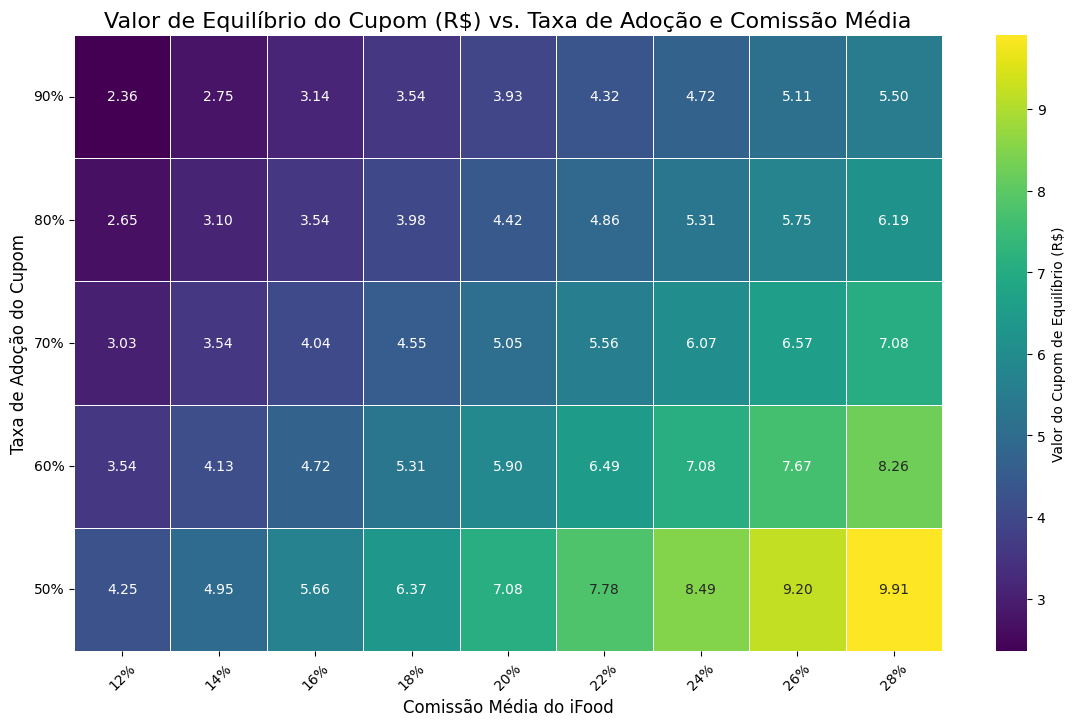

In [ ]:
##Podemos ainda fazer uma analise mais interessante ja que não possuimos os valores acertivos de comissao e taxa de adesão; e plotar possiveis combinações de valores
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Função de cálculo para o ponto de equilíbrio
def calcular_cupom_equilibrio(taxa_adocao, comissao_media):
    """
    Calcula o valor de equilíbrio do cupom com base na taxa de adoção e comissão.
    """
    if taxa_adocao == 0 or comissao_media == 0:
        return 0

    pedidos_incrementais = N_USUARIOS_TESTE * DIFERENCA_FREQ_MEDIA
    gmv_incremental = pedidos_incrementais * AOV_TESTE
    beneficio_incremental = gmv_incremental * comissao_media

    usuarios_que_adotaram = N_USUARIOS_TESTE * taxa_adocao
    cupom_de_equilibrio = beneficio_incremental / usuarios_que_adotaram

    return cupom_de_equilibrio

# --- Passo 2: Definir os Eixos da Análise de Sensibilidade ---
# Faixas de valores para as premissas que queremos variar

# Taxa de Adoção variando de 50% a 90% (em passos de 10%)
taxa_adocao_range = np.arange(0.50, 0.91, 0.1)

# Comissão Média variando de 12% a 27% (de 2 em 2 pontos percentuais)
comissao_range = np.arange(0.12, 0.28, 0.02)


# --- Passo 3: Calcular os Resultados para cada Combinação ---
# Criamos uma matriz para armazenar os resultados do valor do cupom
results_grid = np.zeros((len(taxa_adocao_range), len(comissao_range)))

# Preenchemos a matriz com os resultados
for i, adocao in enumerate(taxa_adocao_range):
    for j, comissao in enumerate(comissao_range):
        results_grid[i, j] = calcular_cupom_equilibrio(adocao, comissao)

# --- Passo 4: Criar e Plotar o Gráfico (Heatmap) ---
print("--- Gerando o Heatmap de Sensibilidade ---")

# Criamos um DataFrame pandas para facilitar a plotagem com Seaborn
# Formatamos os labels dos eixos para porcentagem
taxa_adocao_labels = [f'{val:.0%}' for val in taxa_adocao_range]
comissao_labels = [f'{val:.0%}' for val in comissao_range]

heatmap_df = pd.DataFrame(results_grid, index=taxa_adocao_labels, columns=comissao_labels)
# Invertemos as linhas para o eixo Y ficar crescente no gráfico
heatmap_df = heatmap_df.iloc[::-1]

# Configurações do Gráfico
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_df,
    annot=True,      # Adiciona os valores numéricos em cada célula
    fmt=".2f",       # Formata os números para duas casas decimais
    cmap="viridis",  # Paleta de cores
    linewidths=.5,
    cbar_kws={'label': 'Valor do Cupom de Equilíbrio (R$)'} # Label da barra de cores
)

# Títulos e Labels
plt.title('Valor de Equilíbrio do Cupom (R$) vs. Taxa de Adoção e Comissão Média', fontsize=16)
plt.xlabel('Comissão Média do iFood', fontsize=12)
plt.ylabel('Taxa de Adoção do Cupom', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Exibe o gráfico diretamente na saída do notebook
plt.show()



--- Gerando o Gráfico de Linhas Múltiplas ---


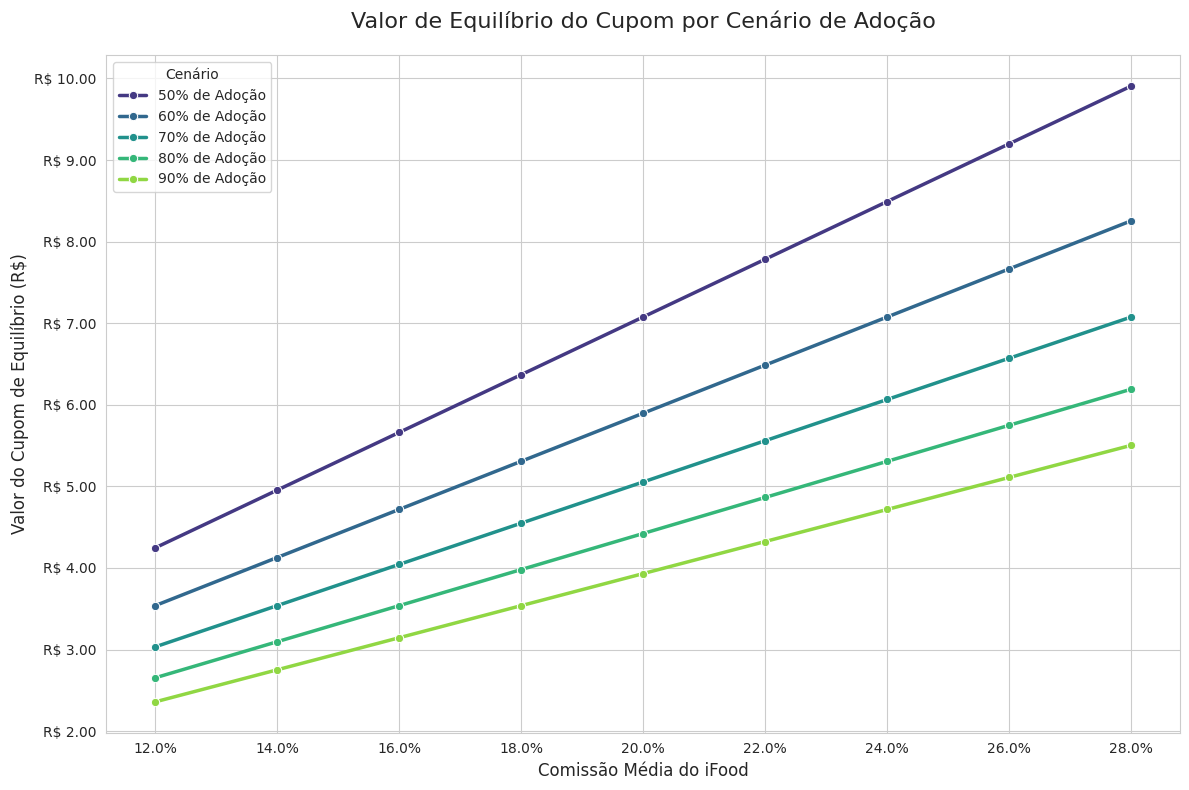

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
# --- Passo 2: Definir os Eixos da Análise ---
# Usamos os mesmos ranges que definimos para o heatmap
taxa_adocao_range = np.arange(0.50, 0.91, 0.1)
comissao_range = np.arange(0.12, 0.28, 0.02)

# --- Passo 3: Criar um DataFrame "Longo" com os Resultados ---
# Em vez de uma matriz, criamos uma lista de registros para o DataFrame.
plot_data = []
for adocao in taxa_adocao_range:
    for comissao in comissao_range:
        valor_cupom = calcular_cupom_equilibrio(adocao, comissao)
        # Adicionamos um dicionário à nossa lista de dados
        plot_data.append({
            # Formatamos a taxa de adoção para usar como legenda
            'taxa_adocao': f'{adocao:.0%} de Adoção',
            'comissao_media': comissao,
            'valor_cupom': valor_cupom
        })

# Convertemos a lista de dados em um DataFrame do Pandas
df_lineplot = pd.DataFrame(plot_data)

# --- Passo 4: Criar e Plotar o Gráfico de Linhas Múltiplas ---
print("--- Gerando o Gráfico de Linhas Múltiplas ---")

# Configurações do Gráfico
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid") # Adiciona uma grade para facilitar a leitura

# Criando o gráfico de linhas
# O parâmetro 'hue' cria uma linha separada para cada valor na coluna 'taxa_adocao'
line_plot = sns.lineplot(
    data=df_lineplot,
    x='comissao_media',
    y='valor_cupom',
    hue='taxa_adocao', # Chave para criar as linhas múltiplas
    palette='viridis',   # Mesma paleta de cores do heatmap
    marker='o',          # Adiciona um marcador em cada ponto de dados
    linewidth=2.5
)

# Títulos e Labels
plt.title('Valor de Equilíbrio do Cupom por Cenário de Adoção', fontsize=16, pad=20)
plt.xlabel('Comissão Média do iFood', fontsize=12)
plt.ylabel('Valor do Cupom de Equilíbrio (R$)', fontsize=12)

# Formatando os eixos para melhor visualização
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('R$ %.2f'))
plt.legend(title='Cenário') # Renomeia o título da legenda

plt.tight_layout()
# Exibe o gráfico diretamente na saída do notebook
plt.show()

## Conclusão Parte 1 da Análise de Viabilidade Financeira (Desafio 1b)

A análise de viabilidade financeira foi projetada para ir além da validação do engajamento e responder a uma pergunta de negócio crucial: a campanha de cupons, como alavanca de crescimento, foi financeiramente sustentável? Para isso, adotamos uma abordagem em duas etapas: primeiro, calculamos um ponto de equilíbrio com base em premissas realistas e, em seguida, expandimos a análise para entender como esse resultado se comporta em diferentes cenários.

### O Ponto de Partida: A Análise de Ponto de Equilíbrio

Adotando um cenário base com premissas realistas — uma **Taxa de Adoção de 60%** e uma **Comissão Média de 18%** — chegamos a um resultado claro:

* O cálculo revelou que o **valor de equilíbrio do cupom é de RS 5,31**.

Isso significa que, neste cenário específico, RS 5,31 é o valor máximo que o desconto poderia ter para que a campanha se pagasse, considerando apenas o ganho de curto prazo gerado pelo aumento de pedidos. Um cupom de RS 7 ou RS 10, nessas condições, geraria um prejuízo imediato.

### Além do Ponto Fixo: A Análise de Sensibilidade

Uma análise baseada em um único ponto é frágil, pois as premissas podem variar. Por isso, realizamos uma **análise de sensibilidade**, visualizada através de gráficos (heatmap e linhas múltiplas), para entender como o valor de equilíbrio do cupom se comporta sob diferentes cenários de comissão e adoção. Os insights foram claros:

1.  **A Comissão é o Fator Dominante:** A visualização mostrou que a comissão média do iFood é a alavanca mais poderosa.
2.  **O Trade-off da Adoção:** Inversamente, uma alta taxa de adoção (ex: 90%) aumenta o custo total da campanha, forçando o valor do cupom de equilíbrio a ser menor para manter a viabilidade.

### Conclusão Estratégica Final

> A análise de viabilidade financeira demonstra que não há uma resposta única para "qual o valor ideal do cupom?". No nosso cenário base (60% de adoção, 18% de comissão), o ponto de equilíbrio é de **RS 5,31**. Contudo, a análise de sensibilidade nos fornece um mapa de decisão: para que o iFood possa oferecer cupons mais agressivos e atrativos (ex: RS 7 ou RS 10), Nesse caso deve-se justificar o prejuízo de curto prazo como um **investimento em LTV (Lifetime Value)**. A campanha é financeiramente viável, mas sua lucratividade depende diretamente dessas duas alavancas estratégicas.

--- Gerando Gráficos de Sensibilidade em Múltiplas Dimensões ---


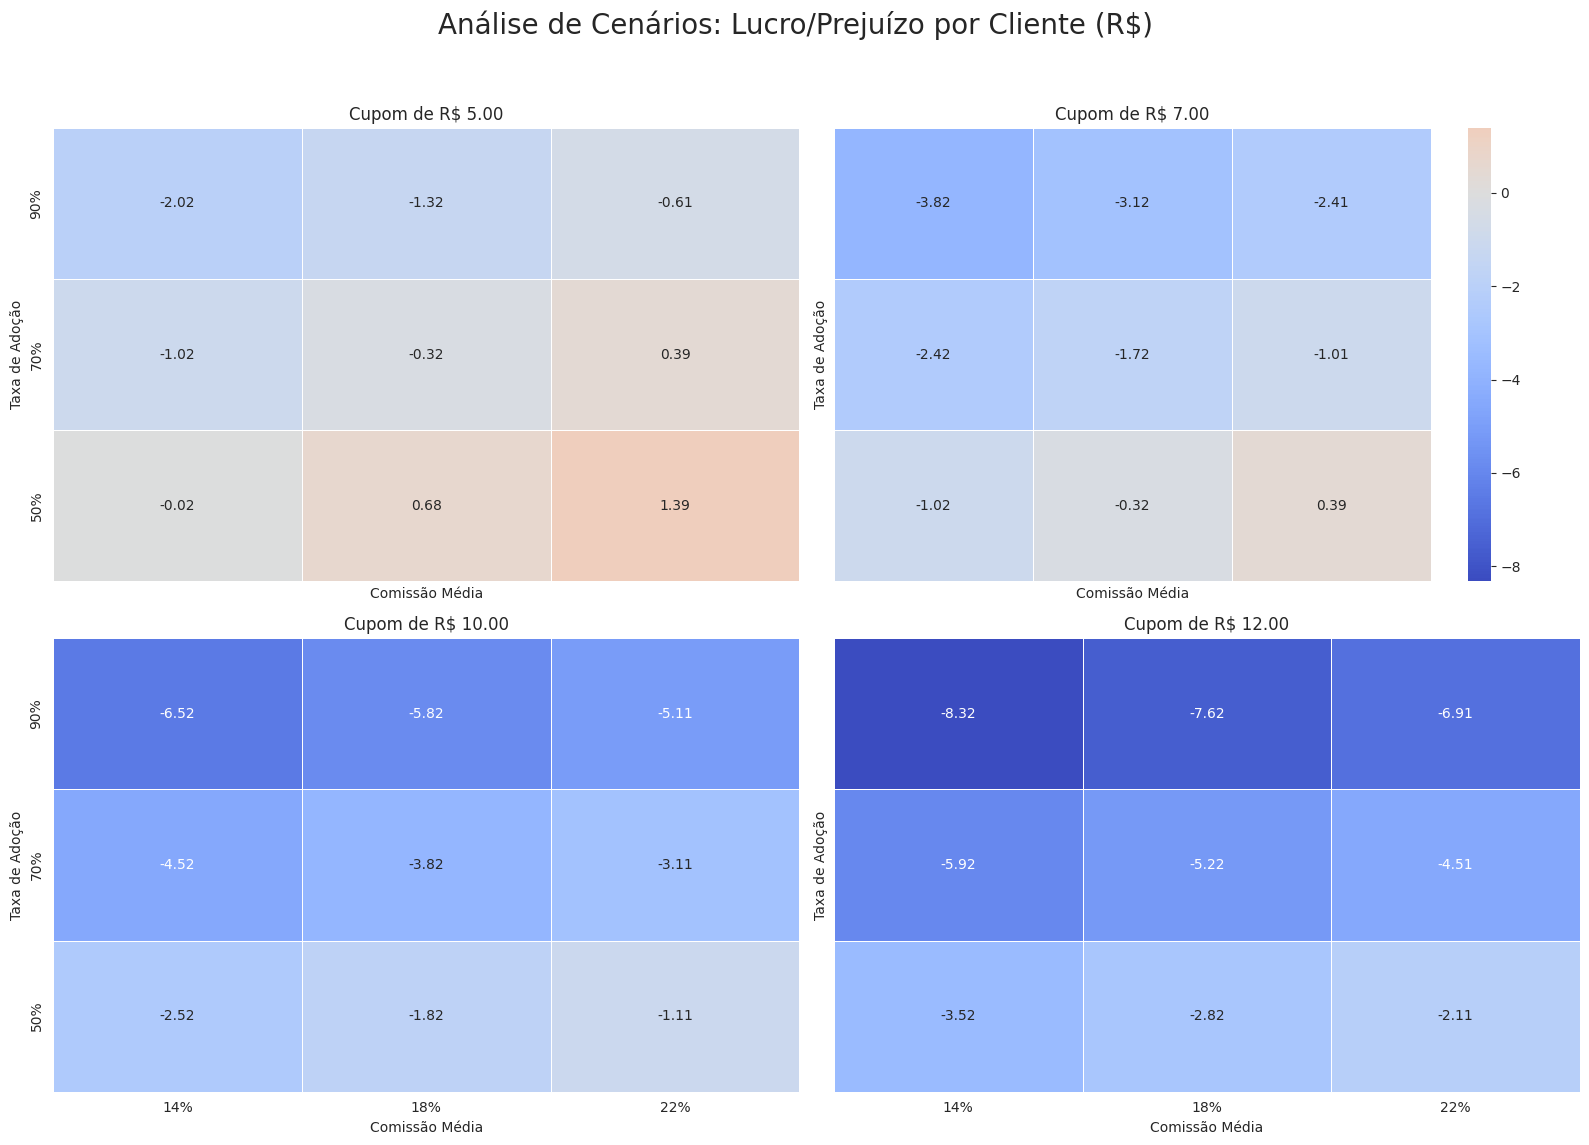

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Passo 1: Definir Inputs Fixos e a Nova Função de Cálculo ---
# Inputs da nossa análise de KPI anterior (não mudam)
N_USUARIOS_TESTE = 444860
DIFERENCA_FREQ_MEDIA = 0.37
AOV_TESTE = 47.81

# A função agora aceita o VALOR_CUPOM como um argumento para a simulação
def calcular_resultado_por_cliente(taxa_adocao, comissao_media, valor_cupom):
    """
    Calcula o prejuízo ou lucro líquido por cliente do grupo teste para um dado valor de cupom.
    """
    if taxa_adocao == 0:
        return 0

    # O benefício médio por usuário depende da comissão
    beneficio_real_por_usuario = (N_USUARIOS_TESTE * DIFERENCA_FREQ_MEDIA * AOV_TESTE * comissao_media) / N_USUARIOS_TESTE

    # O custo médio por usuário depende da adoção e do valor do cupom
    custo_real_por_usuario = valor_cupom * taxa_adocao

    # Resultado líquido é a diferença
    resultado_liquido = beneficio_real_por_usuario - custo_real_por_usuario

    return resultado_liquido

# --- Passo 2: Definir os Eixos da Análise de Sensibilidade ---
# Definimos os ranges para as 3 variáveis que queremos analisar

# Variável 1: Taxa de Adoção
taxa_adocao_range = np.arange(0.50, 0.91, 0.2) # 50%, 70%, 90%

# Variável 2: Comissão Média
comissao_range = np.arange(0.14, 0.26, 0.04) # 14%, 18%, 22%

# Variável 3: Valor do Cupom (nossa terceira dimensão)
range_valor_cupom = np.array([5.00, 7.00, 10.00, 12.00])


# --- Passo 3: Calcular os Resultados para TODAS as Combinações ---
# Vamos armazenar todos os resultados para encontrar os limites globais para a barra de cores
todos_os_resultados = []
for valor_cupom in range_valor_cupom:
    for adocao in taxa_adocao_range:
        for comissao in comissao_range:
            todos_os_resultados.append(calcular_resultado_por_cliente(adocao, comissao, valor_cupom))

# Encontrando o valor mínimo e máximo para uma escala de cores consistente
vmin = min(todos_os_resultados)
vmax = max(todos_os_resultados)

# --- Passo 4: Criar e Plotar os Gráficos em Grade (Facetamento) ---
print("--- Gerando Gráficos de Sensibilidade em Múltiplas Dimensões ---")

# Criamos uma figura com uma grade de subplots (2x2 para os 4 cenários de cupom)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True, sharex=True)

# Iteramos sobre cada valor de cupom e cada eixo do subplot
for i, valor_cupom in enumerate(range_valor_cupom):
    ax = axes.flat[i] # Seleciona o subplot atual

    # Recalcula a grade de resultados para o valor do cupom atual
    results_grid_crc = np.zeros((len(taxa_adocao_range), len(comissao_range)))
    for j, adocao in enumerate(taxa_adocao_range):
        for k, comissao in enumerate(comissao_range):
            results_grid_crc[j, k] = calcular_resultado_por_cliente(adocao, comissao, valor_cupom)

    # Criamos o DataFrame para o heatmap do subplot atual
    taxa_adocao_labels = [f'{val:.0%}' for val in taxa_adocao_range]
    comissao_labels = [f'{val:.0%}' for val in comissao_range]
    heatmap_df_crc = pd.DataFrame(results_grid_crc, index=taxa_adocao_labels, columns=comissao_labels)
    heatmap_df_crc = heatmap_df_crc.iloc[::-1]

    # Plotando o heatmap no subplot 'ax'
    sns.heatmap(
        heatmap_df_crc,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=.5,
        vmin=vmin, # Usamos o mesmo limite mínimo de cor para todos os gráficos
        vmax=vmax, # Usamos o mesmo limite máximo de cor para todos os gráficos
        cbar= (i==1) # Mostra a barra de cores apenas no segundo gráfico para não poluir
    )
    ax.set_title(f'Cupom de R$ {valor_cupom:.2f}')
    ax.set_ylabel('Taxa de Adoção')
    ax.set_xlabel('Comissão Média')


# Título Geral da Figura
fig.suptitle('Análise de Cenários: Lucro/Prejuízo por Cliente (R$)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para o título geral

# Exibe o gráfico
plt.show()

--- Gerando Heatmap do LTV para um AOV Fixo de R$ 48.00 ---


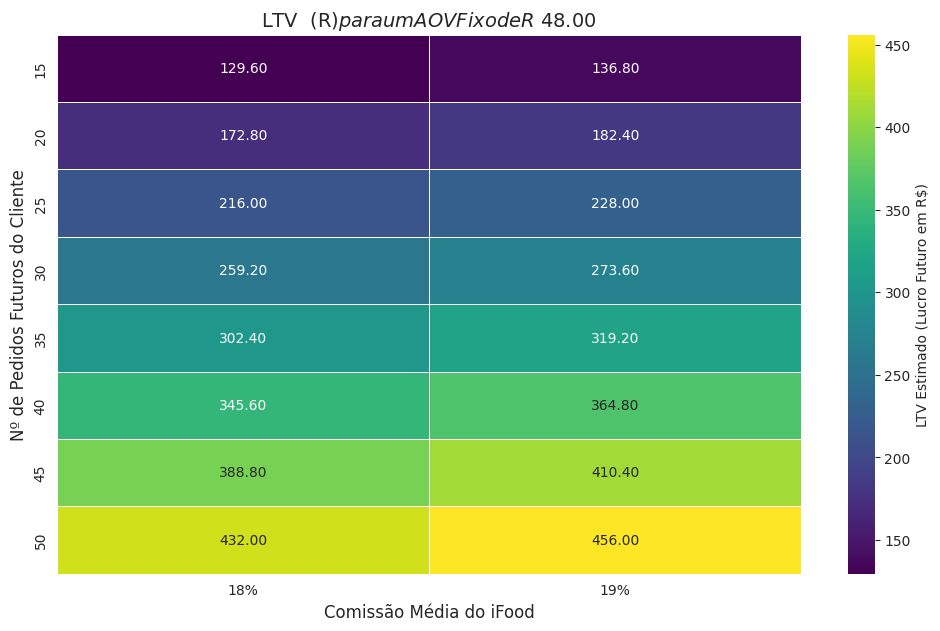

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Passo 1: Definir a Função de Cálculo do LTV ---
def calcular_ltv(num_pedidos, aov, comissao):
    """Calcula o LTV (lucro de comissão) com base nos parâmetros fornecidos."""
    return num_pedidos * aov * comissao

# --- Passo 2: Definir os Parâmetros da Simulação ---
# Variamos o número de pedidos e a comissão para criar os eixos do nosso gráfico.

# Nº de Pedidos Futuros: Quantos pedidos a mais um cliente retido fará?
range_pedidos_futuros = np.arange(15, 55, 5)

# Comissão Futura: Qual a comissão média que o iFood terá nesses pedidos?
range_comissao_media = np.arange(0.18, 0.19, 0.01)

AOV_FUTURO_FIXO = 48.00  # R$
# --- Passo 3: Executar a Simulação ---
# Criamos uma lista para armazenar cada cenário simulado
simulacao_data = []
for pedidos in range_pedidos_futuros:
    for comissao in range_comissao_media:
        ltv_calculado = calcular_ltv(pedidos, AOV_FUTURO_FIXO, comissao)
        simulacao_data.append({
            'pedidos_futuros': pedidos,
            'comissao_media': f'{comissao:.0%}', # Formata para o gráfico
            'ltv_calculado_reais': ltv_calculado
        })

# Convertemos os resultados em um DataFrame do Pandas
df_ltv = pd.DataFrame(simulacao_data)


# --- Passo 4: Visualizar a Simulação (Heatmap) ---
print(f"--- Gerando Heatmap do LTV para um AOV Fixo de R$ {AOV_FUTURO_FIXO:.2f} ---")

# Criamos uma tabela pivot para o heatmap
heatmap_pivot = df_ltv.pivot_table(
    index='pedidos_futuros',
    columns='comissao_media',
    values='ltv_calculado_reais'
)
# Ordenando as colunas de comissão para garantir a ordem correta no gráfico
heatmap_pivot = heatmap_pivot.reindex(sorted(heatmap_pivot.columns), axis=1)


# Plotando o heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=.5,
    cbar_kws={'label': 'LTV Estimado (Lucro Futuro em R$)'}
)

plt.title(f'LTV  (R$) para um AOV Fixo de R$ {AOV_FUTURO_FIXO:.2f}', fontsize=14)
plt.xlabel('Comissão Média do iFood', fontsize=12)
plt.ylabel('Nº de Pedidos Futuros do Cliente', fontsize=12)
plt.show()

## Conclusão da Análise de Cenários Estratégicos (Desafio 1b)

A análise estratégica nos permite ir além do resultado financeiro de curto prazo e avaliar se a campanha de cupons se justifica como um investimento inteligente no crescimento do iFood. A lógica central é comparar o Custo de Retenção de Cliente (CRC) com o seu potencial de lucro futuro, o Lifetime Value (LTV).

### A Análise Direta: Comparando Custo de Retenção (CRC) com LTV

Para ilustrar a relação, vamos analisar um cenário de campanha agressiva e um cenário de LTV moderado:

* **O Custo (CRC):** Em um cenário com um **cupom de RS 10,00** e uma **taxa de adoção de 70%**, o cálculo nos mostra que a campanha gera um prejuízo líquido (ou custo de retenção) de **RS 3,82 por cliente** do grupo teste.

* **O Retorno Potencial (LTV):** Por outro lado, nossa simulação de LTV, mesmo em um cenário conservador (um cliente fazendo **30 pedidos futuros** com **AOV de RS 48** e **comissão de 18%**), projeta um lucro futuro de **RS 259,60** para este mesmo cliente.

A comparação direta mostra que o retorno de longo prazo (`R$ 259,60`) supera massivamente o investimento inicial (`R$ 3,82`), validando o prejuízo de curto prazo como um CRC estrategicamente aceitável.

### A Visão Estratégica: O LTV Dinâmico e o Custo Contínuo de Engajamento

No entanto, uma análise completa não pode assumir que o LTV é um lucro "livre" após o primeiro investimento. O erro seria tratar o CRC como uma taxa única.

A realidade é que a jornada do cliente é influenciada por múltiplas campanhas. O LTV de RS 259,60 é o potencial bruto, mas ele será inevitavelmente impactado pelos custos de futuras ações de marketing necessárias para manter esse cliente ativo e leal. O CRC de RS 3,82 deve ser visto como a "primeira parcela" do investimento total na vida daquele cliente.

O verdadeiro desafio de negócio não é apenas adquirir ou reter o cliente uma vez, mas gerenciar o custo contínuo de mantê-lo engajado.

### Implicações para a Estratégia de Cuponagem do iFood

1.  **Justificativa para o Investimento:** A análise confirma que o potencial de LTV é tão alto que justifica o uso de cupons como ferramenta estratégica, mesmo que gerem prejuízo de curto prazo. A campanha funciona.

2.  **Necessidade de Otimização Contínua:** A questão-chave para o iFood não é "se" deve usar cupons, mas "como", "quando" e "para quem". A estratégia deve evoluir de cupons em massa para uma abordagem mais inteligente.

3.  **Inteligência de Dados como Alavanca:** A análise de LTV por **segmento de cliente** (que será abordada no Desafio 2) torna-se ainda mais crítica. O objetivo deve ser focar os cupons mais caros (e, portanto, com maior CRC) nos segmentos com maior potencial de LTV, enquanto se oferece incentivos de menor custo para segmentos de menor valor.

> **Conclusão Final:** Concluímos que a campanha é **estrategicamente viável**, pois o LTV potencial do cliente retido justifica o Custo de Retenção inicial. Contudo, a visão simplista de "pagar uma vez para lucrar para sempre" é falha. A verdadeira maestria na estratégia de crescimento do iFood residirá em **gerenciar o custo contínuo de engajamento**, utilizando a análise de dados para otimizar a frequência e o valor dos incentivos ao longo de todo o ciclo de vida do cliente, garantindo que o LTV líquido permaneça positivo e robusto.

# Desafio 1-c) Melhorias

- c) Recomende oportunidades de melhoria nessa ação e dese
nhe uma nova proposta de teste A/B para validar essas hipóte
ses.

## Desafio 1c: Oportunidades de Melhoria e Proposta de Novo Teste A/B

Nossa análise validou a campanha de cupons como uma ferramenta eficaz para aumentar o engajamento e a retenção, sem efeitos colaterais negativos significativos. No entanto, a análise também revelou que a abordagem "um cupom para todos" e a sensibilidade financeira da ação abrem espaço para otimizações importantes.

### 1. Oportunidades de Melhoria na Estratégia de Cupons

Identificamos três grandes oportunidades para tornar a estratégia de cupons ainda mais eficiente e lucrativa:

1.  **Segmentação e Personalização (Saindo do "One-Size-Fits-All"):** A maior oportunidade reside em reconhecer que nem todos os clientes são iguais. Um cupom de R$ 7 pode ser um grande incentivo para um usuário novo, mas um custo desnecessário para um cliente já leal que compraria de qualquer forma. A melhoria aqui é criar ofertas **personalizadas** para diferentes segmentos de usuários (ex: novos, ativos, em risco de churn, "heavy users").

2.  **Otimização da Oferta:** O teste avaliou um "cupom especial", mas existem diversos tipos de oferta. Cada uma pode ter um apelo e um custo diferente. Poderíamos testar:
    * **Valor Fixo (R$) vs. Percentual (%):** Um desconto de 20% pode ser psicologicamente mais atraente para pedidos grandes, enquanto um de R$ 10 fixo pode ser melhor para pedidos menores.
    * **Frete Grátis:** Para muitos usuários, o custo da entrega é a maior barreira. Frete grátis pode ser um incentivo mais poderoso e, dependendo da logística, mais barato para o iFood do que um desconto direto.

3.  **Gatilhos Comportamentais (Behavioral Triggers):** Em vez de simplesmente "dar" um cupom, podemos usá-lo para incentivar ações específicas que são valiosas para o negócio. Isso transforma o cupom de um brinde em uma recompensa.
    * *Exemplos:* "Faça mais um pedido este mês e ganhe frete grátis no próximo", "Experimente uma nova categoria de restaurante e ganhe R$ 10 de desconto", "Avalie seus últimos 3 pedidos e ganhe um cupom".

### 2. Desenho de um Novo Teste A/B: "Campanha de Cuponagem Inteligente"

Para validar as oportunidades de melhoria, principalmente a de **segmentação**, proponho um novo Teste A/B (na verdade, um Teste A/B/C/D) mais sofisticado.

**a) Hipótese Central:**
> Uma estratégia de cupons **segmentada e personalizada** gerará um **ROI Estratégico (baseado em LTV) superior** a uma campanha de cupom único, ao otimizar o custo e maximizar o engajamento de cada perfil de usuário.

**b) Grupos do Experimento:**
Dividiríamos a base de usuários em quatro grupos para isolar os efeitos:

* **Grupo A (Controle Global):** Não recebe nenhum cupom. Serve como nossa baseline para medir o comportamento orgânico.
* **Grupo B (Controle da Campanha - "One-Size-Fits-All"):** Recebe o cupom "campeão" da análise anterior (ex: um cupom de R$ 5,31, nosso ponto de equilíbrio). Este grupo nos permite comparar o novo modelo com o antigo.
* **Grupo C (Teste - Foco em Ativação de Novos Usuários):** Este grupo seria composto por usuários novos ou com poucos pedidos. A oferta seria mais agressiva para estimular o hábito.
    * *Oferta Exemplo:* "50% de desconto no seu primeiro ou segundo pedido, limitado a R$ 15".
* **Grupo D (Teste - Foco em Retenção e Lealdade):** Este grupo seria composto por usuários já ativos. A oferta seria um "prêmio" para incentivar a recorrência, com um custo menor.
    * *Oferta Exemplo:* "Frete grátis após o 3º pedido realizado no mês".

**c) Métricas a Serem Avaliadas:**
* **Métrica Primária (North Star):** **ROI Estratégico por Segmento**. Calculado como `(LTV Incremental do Segmento - Custo da Campanha no Segmento)`. Isso nos dirá se o investimento em cada tipo de usuário se paga a longo prazo.
* **Métricas Secundárias:** Taxa de Retenção, Frequência de Compra, Dias de Atividade, Ticket Médio (AOV). Todas devem ser analisadas **dentro de cada grupo e segmento**.
* **Métricas de Guarda:** AOV geral da plataforma e a análise de "Impacto em Restaurantes de Alto Valor", para garantir que a nova estratégia não cause desequilíbrios inesperados no ecossistema.

**d) Duração e Critérios de Sucesso:**
* **Duração:** 4 a 6 semanas para a aplicação das ofertas, com um período de acompanhamento de 3 a 6 meses para calcular o LTV incremental.
* **Critérios de Sucesso:** O novo teste será considerado um sucesso se:
    1.  Pelo menos um dos grupos de teste (C ou D) apresentar um ROI Estratégico superior ao do grupo B (o cupom genérico).
    2.  Nenhuma métrica de guarda for significativamente prejudicada em comparação com o Controle Global (Grupo A).